In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f, gamma
import scipy.stats as ss
from scipy.signal import lfilter
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Plotting libraries
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches

# Bioinformatics
from pysam import AlignmentFile, FastxFile
import mappy as mp

# Storage
import pickle

mpl.rcParams['figure.dpi'] = 300

## 1. Extract fasta deleted region


```bash
ref=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/reference.fa
out=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/ancestral_region.fa
samtools faidx $ref Chrom_1:6749498-7706692 > $out

# Position of the deletion
# pmin=6749498
# pmax=7706692

raw
>Chrom_1:6749498-7706692
Total size: 957195
```

## 2. Align simulated and real reads with minimap2


### 2.1 Symlinks

```bash
ln -s /media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/READS/PAG10697.PAF32118a.validated.pass.fastq.gz /media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/PAG10697.PAF32118a.validated.pass.fastq.gz
```

### 2.2 Downsample reads (long reads selection)

#### 2.2.1 Real reads

```bash
input_reads=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/PAG10697.PAF32118a.validated.pass.fastq.gz
output_reads=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/filtered_real_reads.fasta.gz # output in fasta
reformat.sh in=$input_reads out=$output_reads minlength=15000
```

#### 2.2.2 Simulated dataset (merged)

```bash
input_reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/reads_simulated_merged_aligned_reads.fasta
output_reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_merged_aligned_reads.fasta
reformat.sh in=$input_reads out=$output_reads minlength=15000
```

#### 2.2.3 Simulated dataset (separated)

```bash
input_reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/reads_simulated_separated_aligned_reads.fasta
output_reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_separated_aligned_reads.fasta
reformat.sh in=$input_reads out=$output_reads minlength=15000
```

### 2.3 Alignments
#### 2.3.1 Real reads

```bash
### in align-env
deletion=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/ancestral_region.fa
threads=40

reads=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/filtered_real_reads.fastq.gz

# -Y is important to avoid hard clipping
output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.mm2.sorted.bam
minimap2 -Y -t $threads -ax map-ont $deletion $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.mm2_splice.sorted.bam
minimap2 -Y -t $threads -ax splice -G400k $deletion $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.ngmlr.sorted.bam
ngmlr --no-smallinv -x ont -t $threads -r $deletion -q $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.gm2.sorted.bam
graphmap2 align -r $deletion -d $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output
```

#### 2.3.2 Simulated split reads

```bash
### in align-env
reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_separated_aligned_reads.fasta

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.mm2.sorted.bam
minimap2 -Y -t $threads -ax map-ont $deletion $reads | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.mm2_splice.sorted.bam
minimap2 -Y -t $threads -ax splice -G400k $deletion $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.ngmlr.sorted.bam
ngmlr --no-smallinv -x ont -t $threads -r $deletion -q $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.gm2.sorted.bam
graphmap2 align -r $deletion -d $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output
```

#### 2.3.3 Simulated merged reads

```bash
### in align-env
reads=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_merged_aligned_reads.fasta

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.mm2.sorted.bam
minimap2 -Y -t $threads -ax map-ont $deletion $reads | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.mm2_splice.sorted.bam
minimap2 -Y -t $threads -ax splice -G400k $deletion $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.ngmlr.sorted.bam
ngmlr --no-smallinv -x ont -t $threads -r $deletion -q $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output

output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.gm2.sorted.bam
graphmap2 align -r $deletion -d $reads | samtools view -h -@ $threads -F 4 | samtools sort -@ $threads -l9 -o $output
```

### 2.4. Align simulated deletion sequences (not reads)
#### 2.4.1. Merged sequences

```bash
deletions_merged=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.merged.fa
output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_ref.mm2.sorted.bam
minimap2 -Y -t $threads -a $deletion $deletions_merged | samtools sort -@ $threads -l9 -o $output
```

#### 2.4.2 Align split deletion sequences (not reads)

```
deletions_split=/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.separated.fa
output=/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_split_v_ref.mm2.sorted.bam
minimap2 -Y -t $threads -a $deletion $deletions_split | samtools sort -@ $threads -l9 -o $output
```

### 2.5. Index bam files

```bash
for file in `ls /media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/*.bam`; do
samtools index $file
done
```

## 3. Compare alignments

In [2]:
# Returns a matrix of positions and whether a given read is aligned on it
def read_bam(bamf, read_lengths, length, chromosome, start, end, minlen=5e3, min_mapq=59) :
    """
    Takes bamf (filepath) and length (int) as input.
    Length is the length of the reference sequence reads are aligned to
    """
    
    bam = AlignmentFile(bamf, "r")
    
    reads_idx = {} # Store position of read in matrix (row)
    matrix = [] # columns = position along reference, rows = individual reads
    
    idx = -1
    iter = bam.fetch(chromosome, start, end)
    for r in iter :
        
        
        # return number of aligned bases of read overlapping the interval start and end on the reference sequence.
        refstart, refend = r.reference_start, r.reference_end
        ovl = r.get_overlap(refstart, refend)
        
        # If aligned bases (overlap computed above) is lower than minlen : do not store this alignment
        # Avoid that large numbers of "N" in CIGAR string create artificially long matches in real dataset
        # Whereas actual alignment is small
        if ovl < minlen or r.mapping_quality < min_mapq :
            continue
        
        qn = r.query_name
        if qn not in reads_idx :
            idx += 1
            reads_idx[qn] = idx
            a = np.empty(1000)
            a[:] = np.nan
            matrix.append(a)
            cidx = idx
        else :
            cidx = reads_idx[qn]
            
        aln_pos = matrix[cidx]
        
        read_length = read_lengths[qn]
        
        """
        reflen = refend - refstart
        ref_show = np.zeros(reflen).astype(int)
        for block in r.get_blocks() :
            
            # length of block
            if block[1] - block[0] >= 1000 : # minimum block size = 1e3
                ref_show[block[0] - refstart]
            
            break
            pass
        """
        
        for prd, prf in r.get_aligned_pairs(matches_only=True) :
            
            read_prop = prd/read_length
            ref_pos = int((prf/length)*1000)
            aln_pos[ref_pos] = read_prop
    
    return matrix, reads_idx

In [3]:
fasta = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/ancestral_region.fa"
f = open(fasta, "r")

length = 0
for line in f :
    if line.startswith(">") :
        continue
    else :
        length += len(line.strip())

f.close()
print(length)

957195


## Plots

In [4]:
def sort_matrix(mat) :
    rows = np.array([[-1 if np.isnan(i) else i for i in r] for r in mat])
    
    # Cluster
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(rows)

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Order
    dendro = dendrogram(linkage_matrix, no_plot=True)
    idx = (dendro["leaves"])
    rows_sorted = rows[idx]
    
    # Replace
    rows_sorted[(rows_sorted == -1)] = np.nan
    return rows_sorted

#>Chrom_1:6749498-7706692
#Total size: 957195
def plot_matrix(matrix, title="", start=6749498, end=7706692, length=957195, delstart=7047000, delend=7383000, figsize=(8,8)) :
    fig, ax = plt.subplots(figsize=figsize)

    masked_array = np.ma.array(matrix, mask=np.isnan(matrix))
    cmap = mpl.cm.seismic
    
    colors = [(1, 0, 0), (0, 0, 0)] # first color is black, last is red
    cmap = LinearSegmentedColormap.from_list("Custom", colors, N=50)
    cmap.set_bad(color='white')

    ax.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
    
    ax.tick_params(axis="y", length=0)
    ax.set_yticks([])
    ax.set_ylabel("Reads aligned")
    
    ax.set_xlabel("Position along deletion")
    xticks = np.arange(0, 1001, 100)
    ax.set_xticks(xticks)
    ax.set_xticklabels(["{:.2f}M".format( (start + int((i*(length/1000))))/1e6 ) for i in xticks])
    
    ax.set_xlim(0,1000)
    
    ax.set_title(title)
    
    plot_del_start = int( ((end - delstart) / length)*1000 )
    plot_del_end = int( ((end - delend) / length)*1000 )
    #print(plot_del_start)
    ax.axvline(plot_del_start, 0, 1, color="k") , #plot_del_end], ymin=0, ymax=len(matrix), color="k", zorder=10)
    ax.axvline(plot_del_end, 0, 1, color="k")
    
    plt.show()

# 0. Get read length in a dict

### 0.1 Real dataset

In [7]:
filename = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/filtered_real_reads.fastq.gz"
real_reads_length = {}
with FastxFile(filename) as fh:
    for entry in fh:
        real_reads_length[entry.name] = len(entry.sequence)

file = open('real_reads_length_dict.pkl', 'wb')
pickle.dump(real_reads_length, file)
file.close()

In [5]:
file = open('real_reads_length_dict.pkl', 'rb')
real_reads_length = pickle.load(file)
file.close()

### 0.2 Simulated reads (merged)

In [12]:
filename = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_merged_aligned_reads.fasta"
sim_reads_merged_length = {}
with FastxFile(filename) as fh:
    for entry in fh:
        sim_reads_merged_length[entry.name] = len(entry.sequence)

file = open('sim_merged_reads_length_dict.pkl', 'wb')
pickle.dump(sim_reads_merged_length, file)
file.close()

In [6]:
file = open('sim_merged_reads_length_dict.pkl', 'rb')
sim_reads_merged_length = pickle.load(file)
file.close()

### 0.3 Simulated reads (separated)

In [14]:
filename = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/SIMULATED_READS/filtered_reads_simulated_separated_aligned_reads.fasta"
sim_reads_sep_length = {}
with FastxFile(filename) as fh:
    for entry in fh:
        sim_reads_sep_length[entry.name] = len(entry.sequence)

file = open('sim_sep_reads_length_dict.pkl', 'wb')
pickle.dump(sim_reads_sep_length, file)
file.close()

In [7]:
file = open('sim_sep_reads_length_dict.pkl', 'rb')
sim_reads_sep_length = pickle.load(file)
file.close()

In [8]:
print(len(real_reads_length), len(sim_reads_merged_length), len(sim_reads_sep_length))

3546957 9893 9825


# 1. minimap2
### Real dataset

In [11]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.mm2.sorted.bam"
matrix_real, reads_idx_real = read_bam(bamf, real_reads_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_real = sort_matrix(matrix_real)

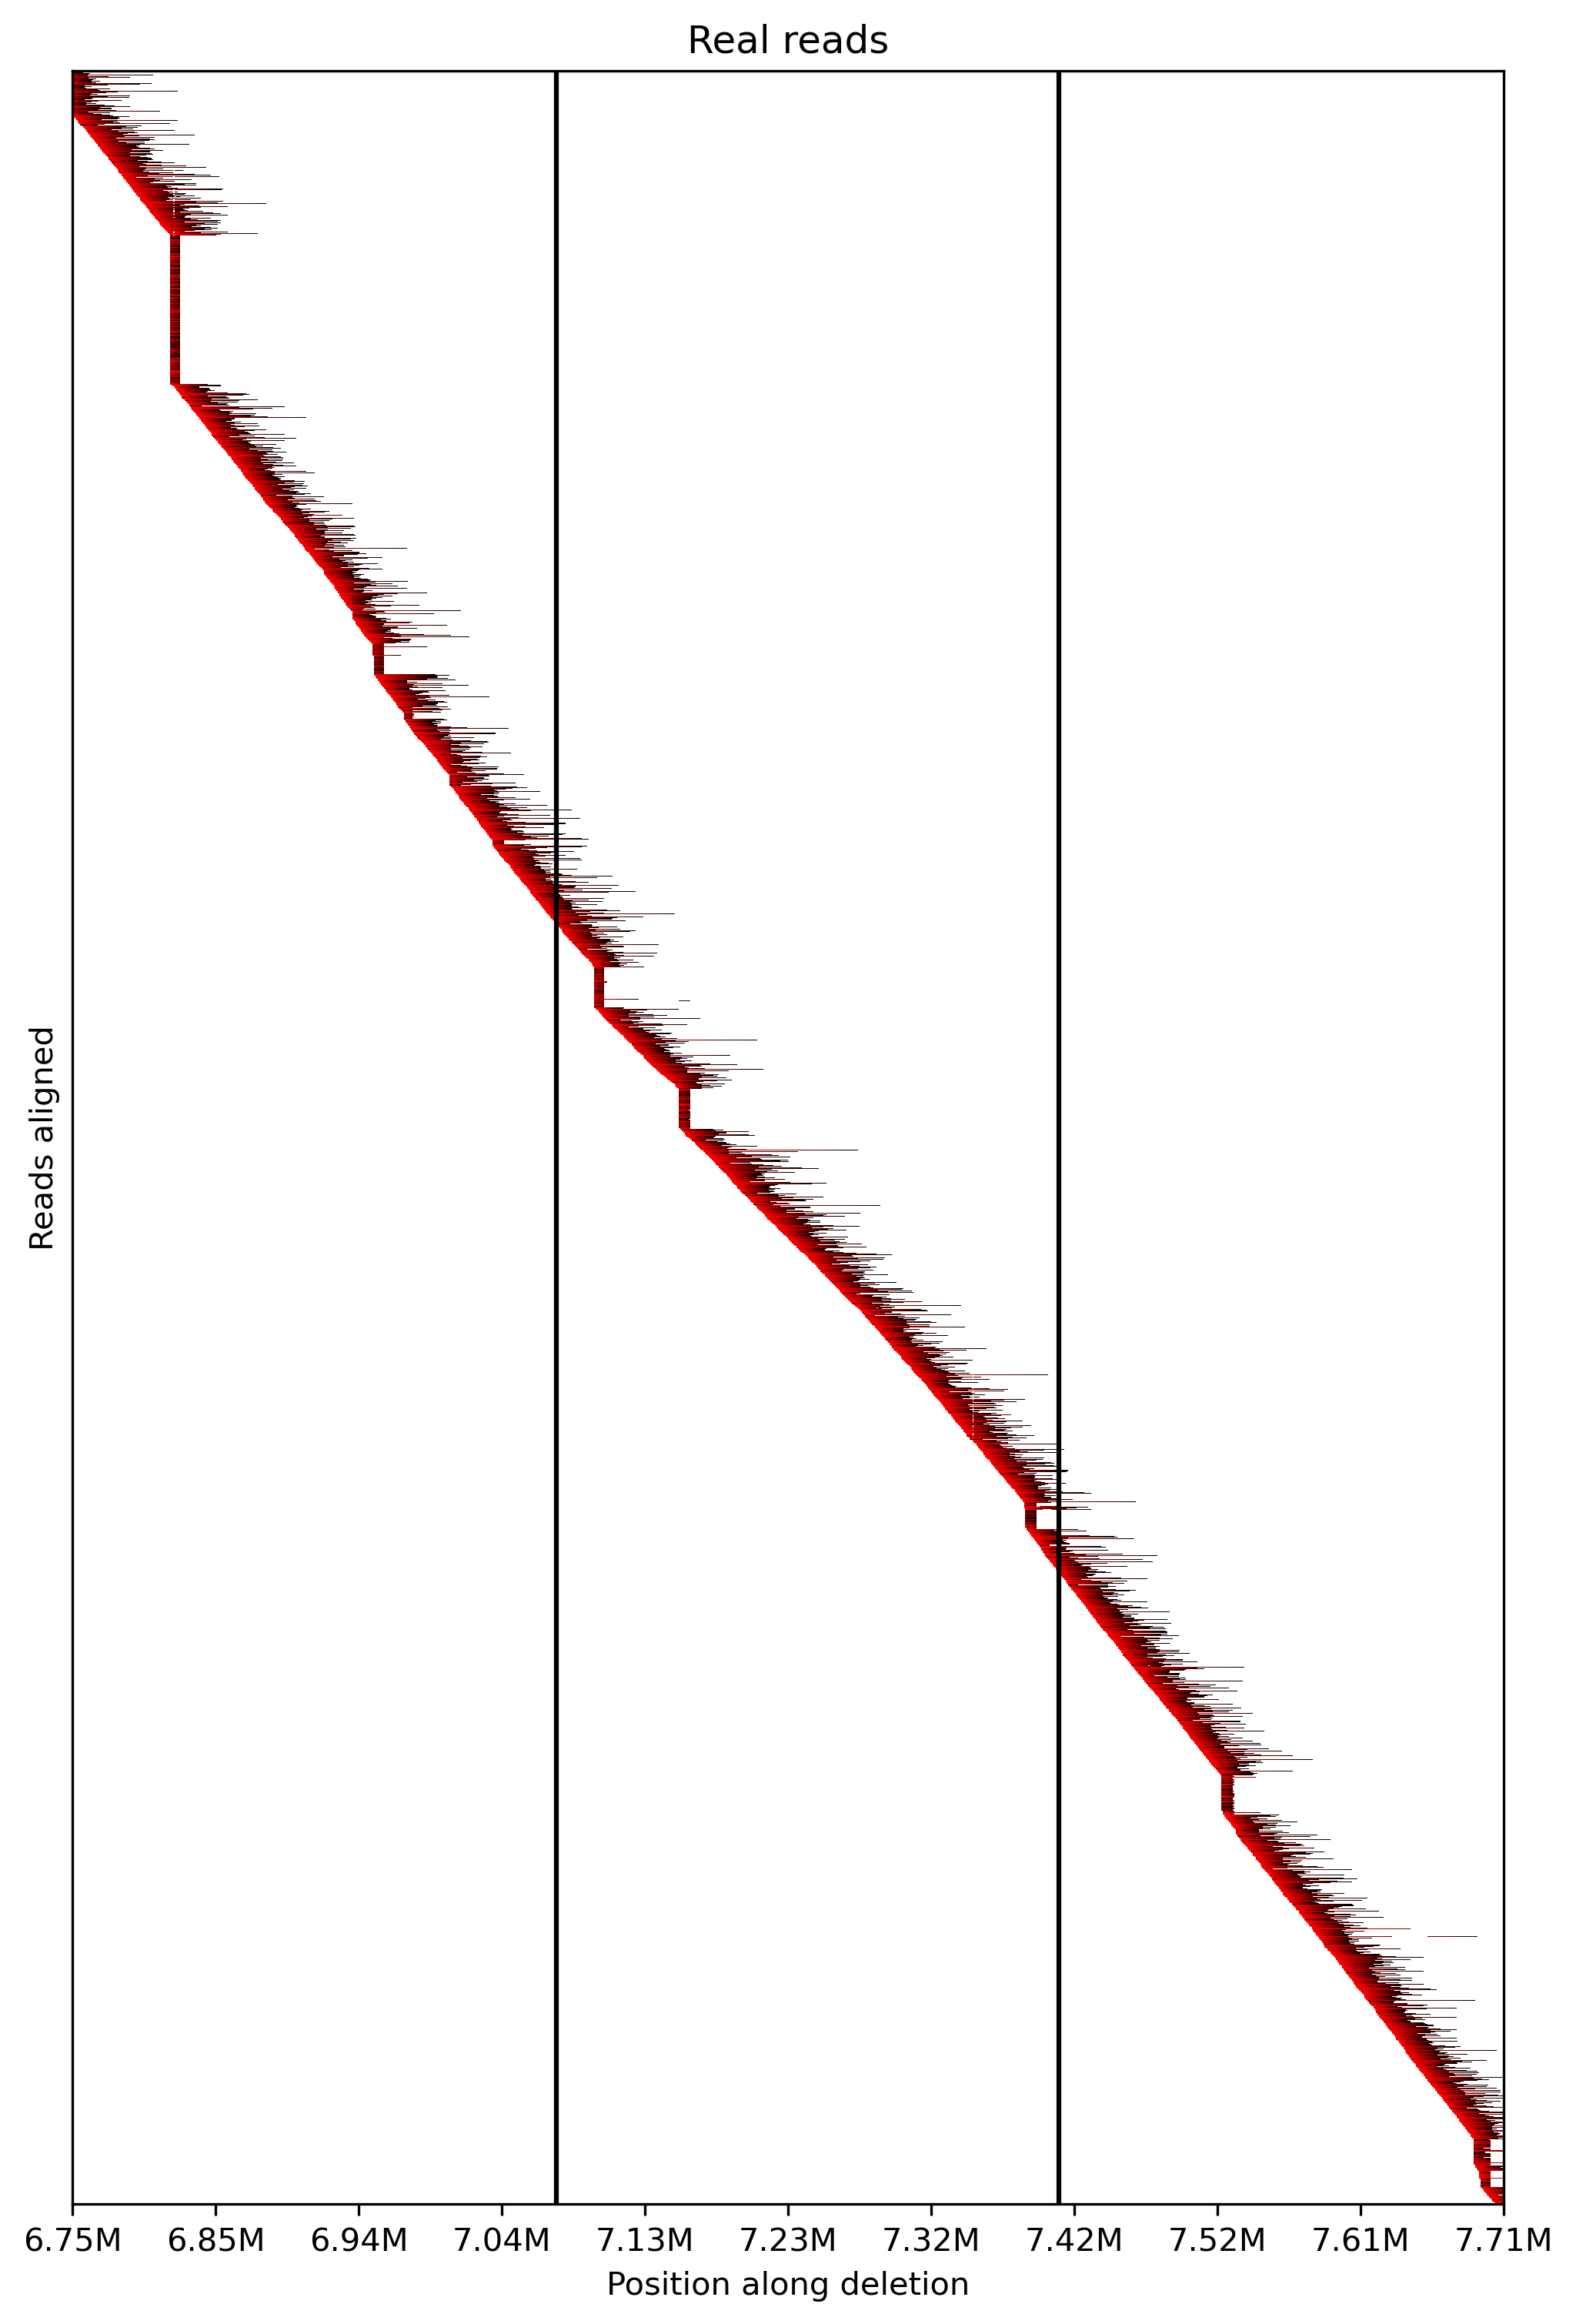

In [13]:
plot_matrix(matrix_real, figsize=(8,12), title="Real reads")

In [14]:
no_small_real = []
for r in matrix_real :
    if np.nansum(r) > 6 :
        no_small_real.append(r)

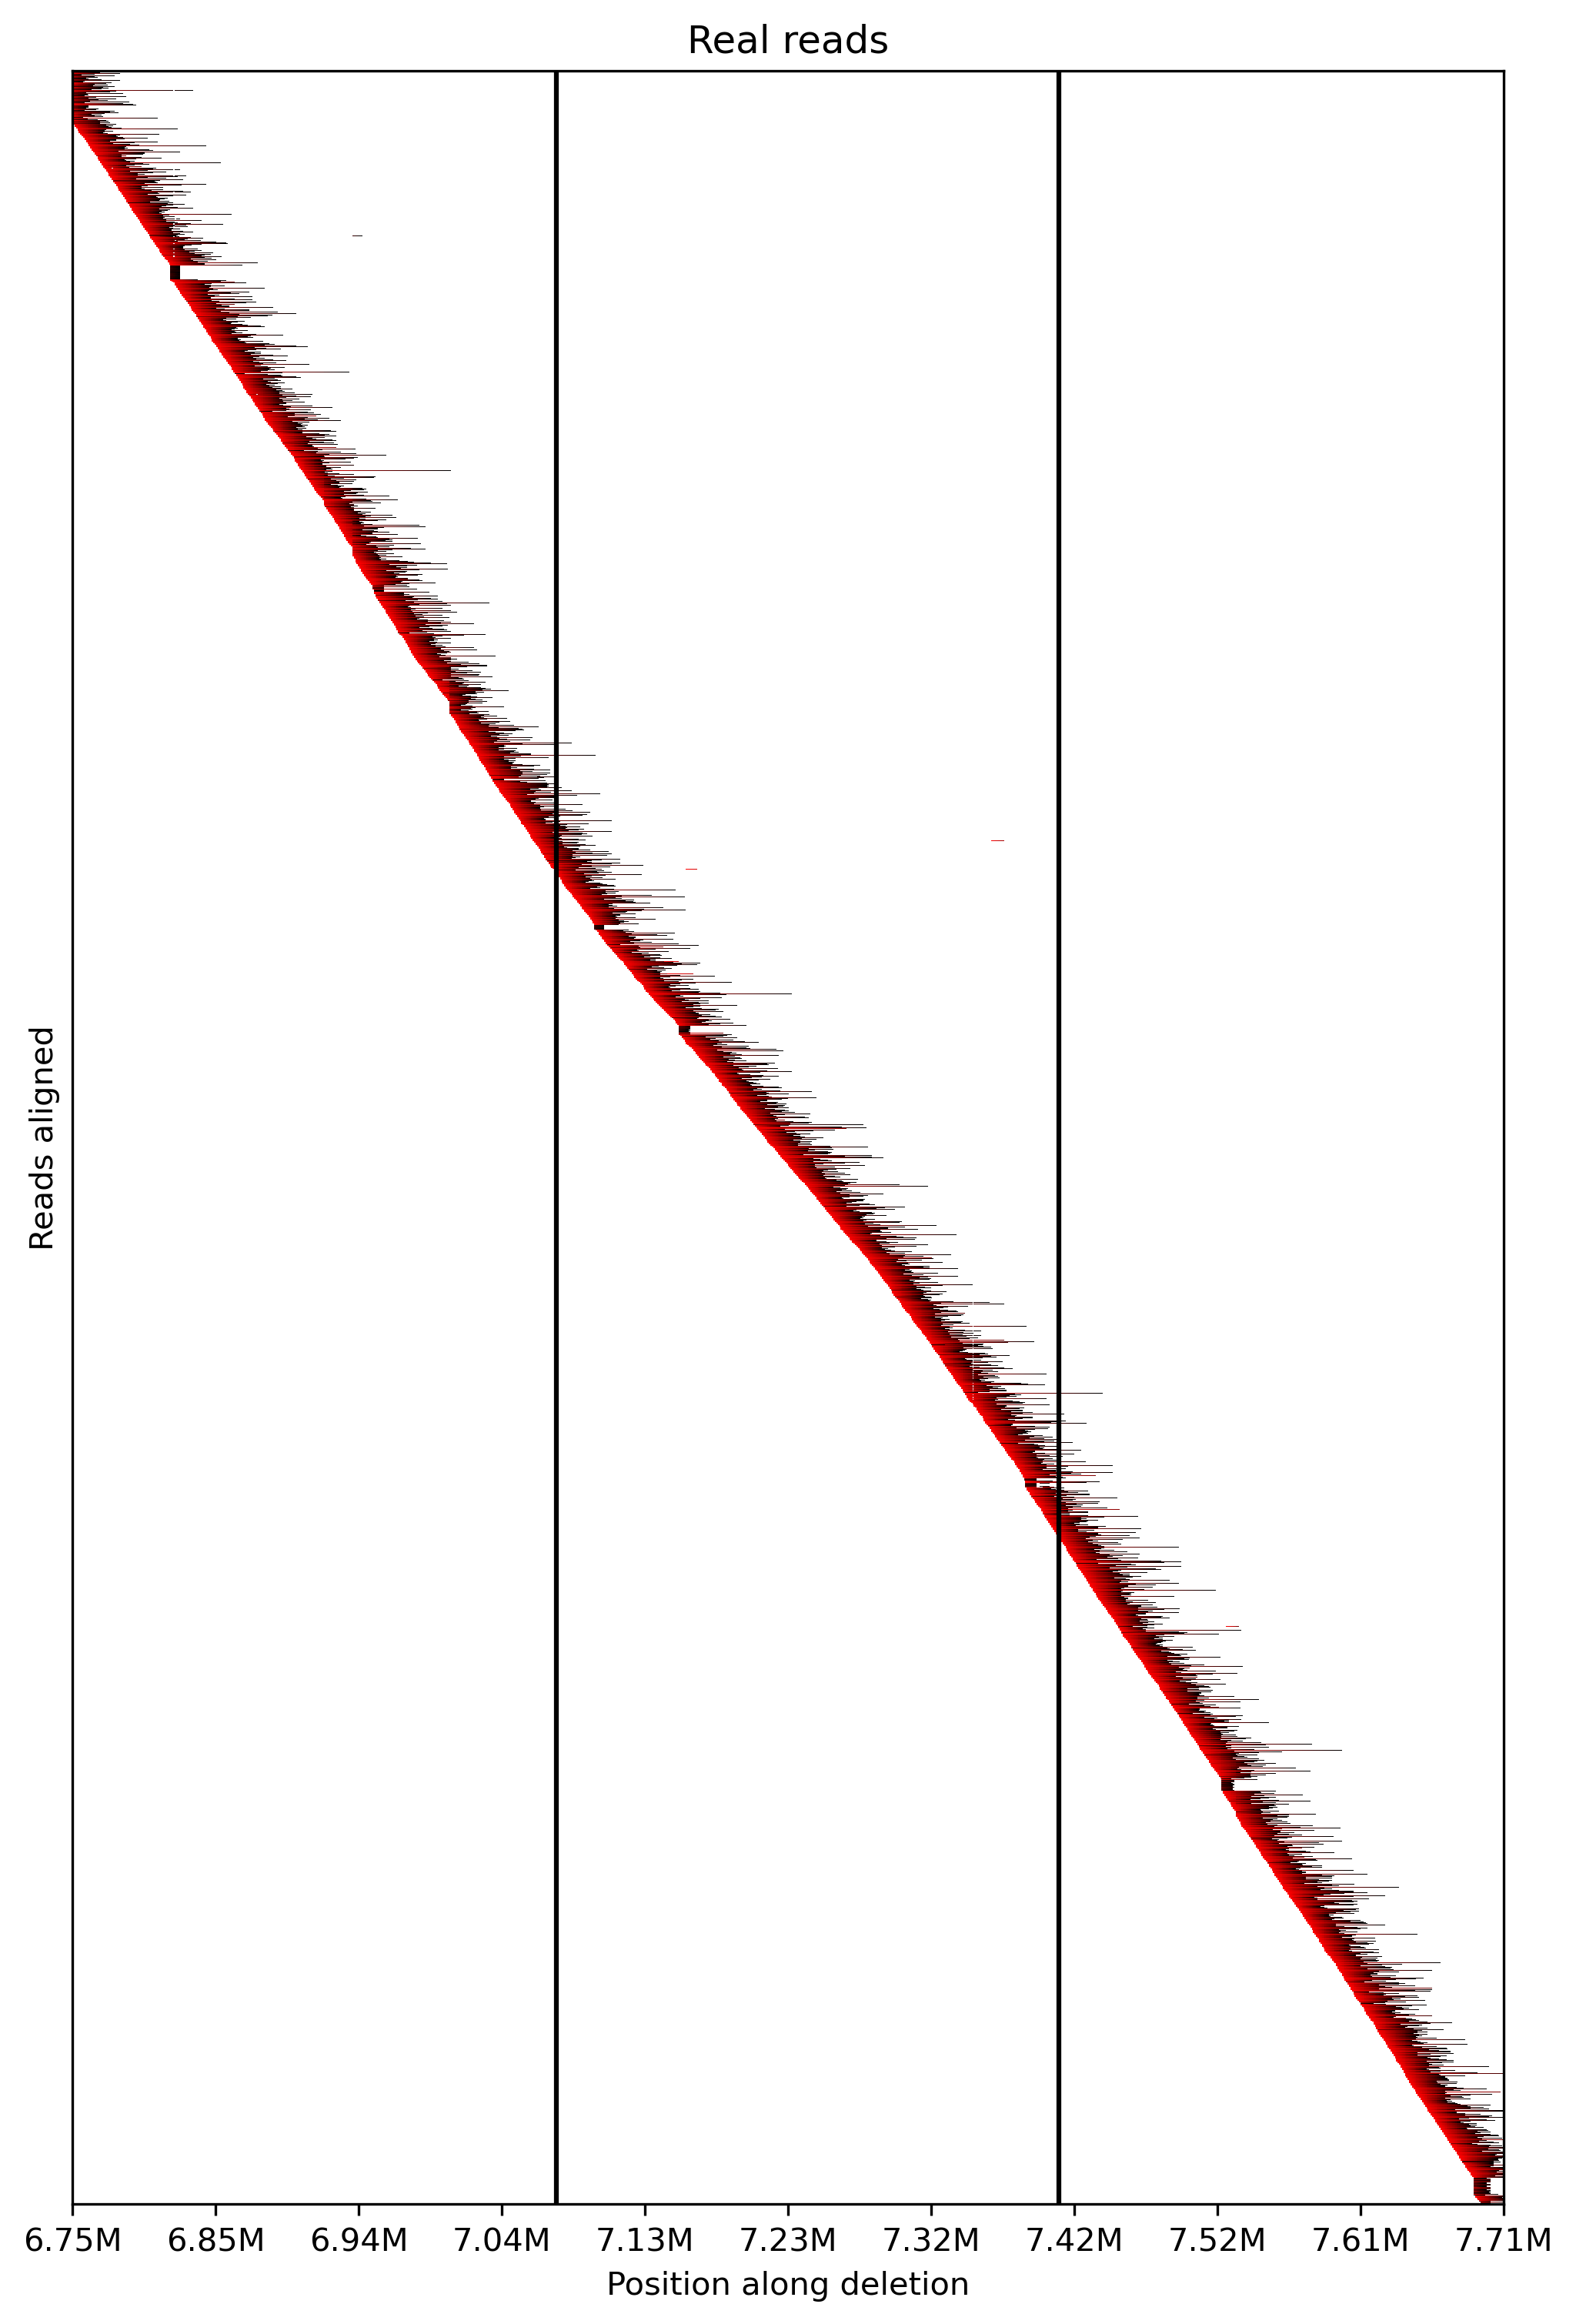

In [15]:
plot_matrix(no_small_real, figsize=(8,12), title="Real reads")

### Simulated sequences (deletions merged)

In [5]:
filename = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.merged.fa"
sim_seqs_merged_length = {}
with FastxFile(filename) as fh:
    for entry in fh:
        sim_seqs_merged_length[entry.name] = len(entry.sequence)

In [6]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_ref.mm2.sorted.bam"
matrix_simseq, reads_idx = read_bam(bamf, sim_seqs_merged_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)

#### Given an array of values and NaNs, sort the arrays by starting position of the longest cluster of non-NaN values

In [7]:
def get_start(arr) :
    #print(read)
    # Initialize variables to track current cluster of non-nan values
    start_pos = None
    stop_pos = None

    # Initialize list to store results
    max_start = None
    max_length = None

    # Loop over elements of input array
    for i in range(len(arr)):
        if not np.isnan(arr[i]): # Check if current element is non-nan
            stop_pos = i # Update stop position of current cluster
            if start_pos is None: # If start position is not set yet, update it
                start_pos = i

        elif start_pos is not None: # Check if current element is nan and the current cluster is non-empty
            # Add start position, stop position, and length of current cluster to results
            length = stop_pos - start_pos + 1
            if max_length is None or length > max_length :
                max_length = length
                max_start = start_pos

            # Reset start position and stop position for new cluster
            start_pos = None
            stop_pos = None

    # Check if there is an open cluster at the end of the array
    if start_pos is not None:
        length = stop_pos - start_pos + 1
        if max_length is None or length > max_length :
            max_length = length
            max_start = start_pos

        # Reset start position and stop position for new cluster
        start_pos = None
        stop_pos = None
    
    if max_start is None :
        return 0
    else :
        return max_start

In [8]:
start_values = np.apply_along_axis(get_start, axis=1, arr=matrix_simseq)
sorted_indices = [i for i, x in sorted(enumerate(start_values), key=lambda x: x[1])]

In [12]:
matrix_simseq_sorted_by_start = [matrix_simseq[i] for i in sorted_indices]
smatrix_simseq = sort_matrix(matrix_simseq)

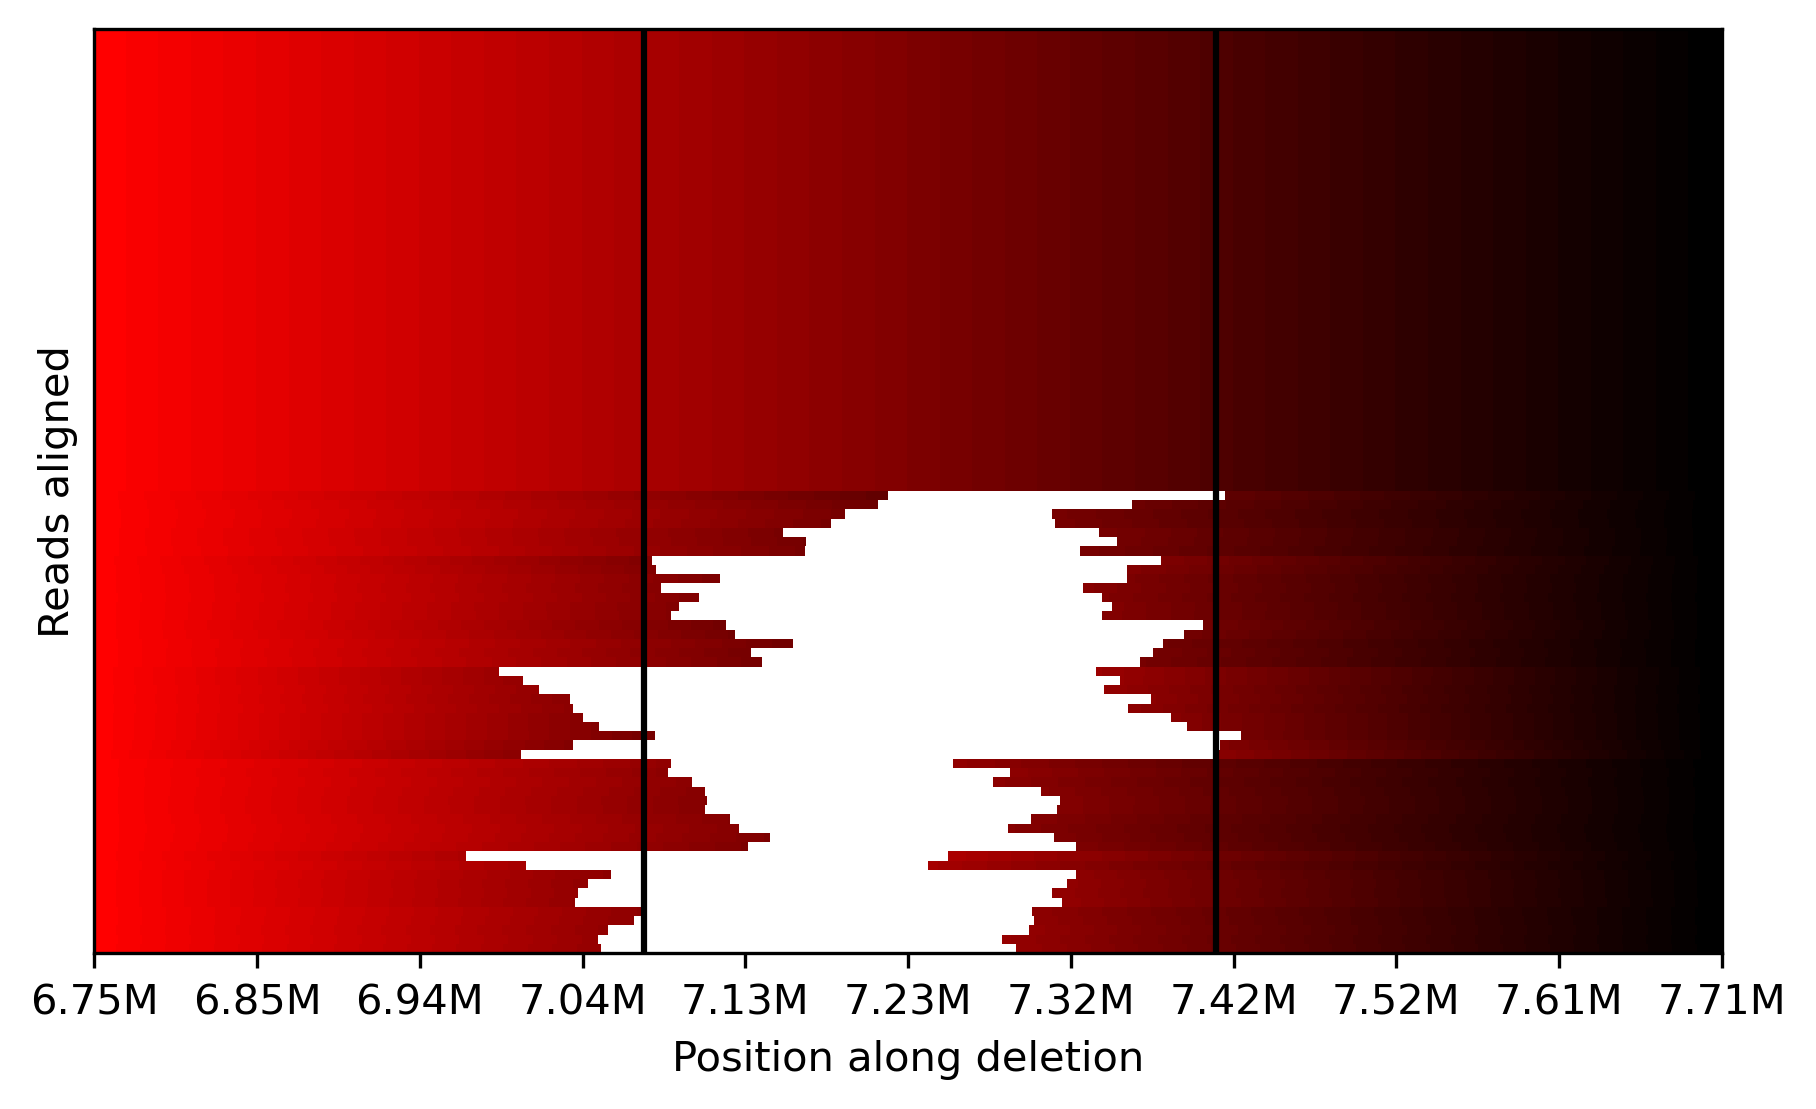

In [13]:
plot_matrix(smatrix_simseq, figsize=(7,4))

### Simulated sequences (deletions split)

In [14]:
filename = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/deletion_simulation_1.separated.fa"
sim_seqs_sep_length = {}
with FastxFile(filename) as fh:
    for entry in fh:
        sim_seqs_sep_length[entry.name] = len(entry.sequence)

In [15]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_split_v_ref.mm2.sorted.bam"
matrix_simseq2, reads_idx = read_bam(bamf, sim_seqs_sep_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_simseq2 = sort_matrix(matrix_simseq2)

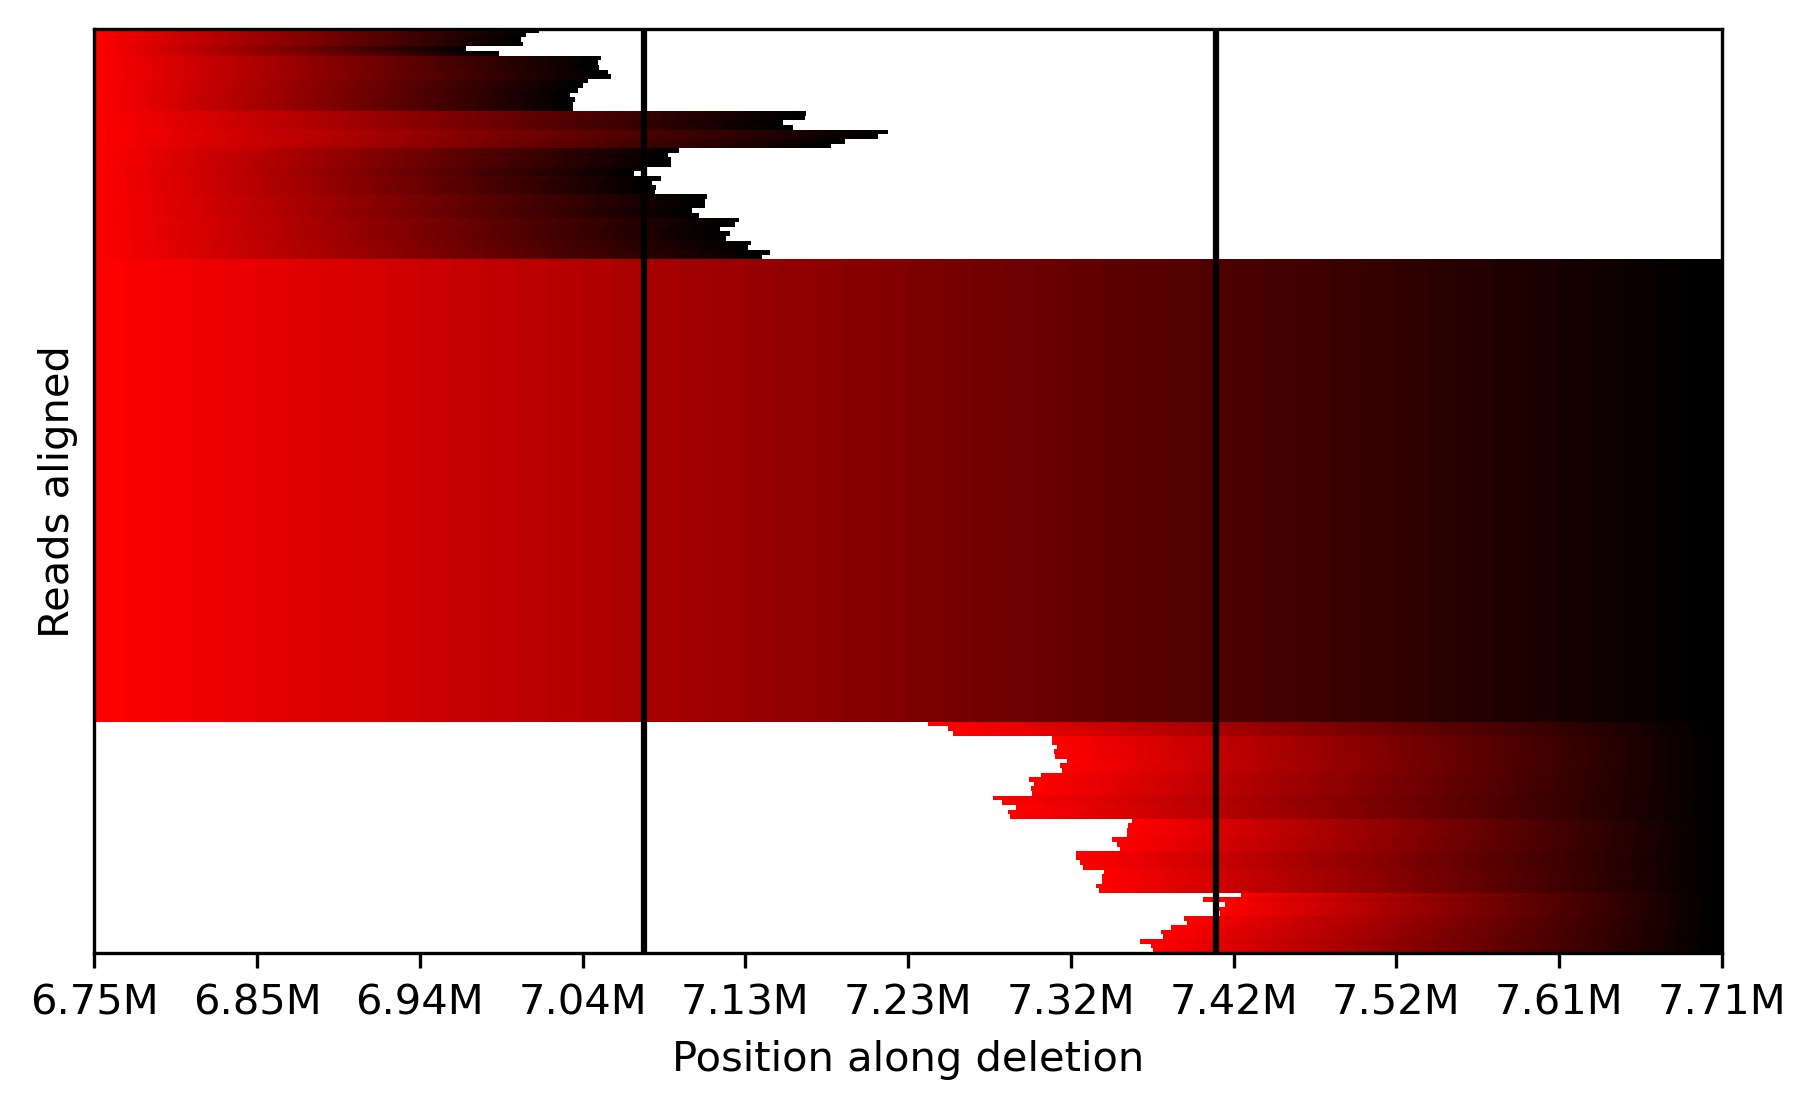

In [16]:
plot_matrix(smatrix_simseq2, figsize=(7,4))

### Simulated dataset (round 2, no free fragments - deletion merged)

In [23]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.mm2.sorted.bam"
matrix_sim_reads, reads_idx = read_bam(bamf, sim_reads_merged_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_sim_reads = sort_matrix(matrix_sim_reads)

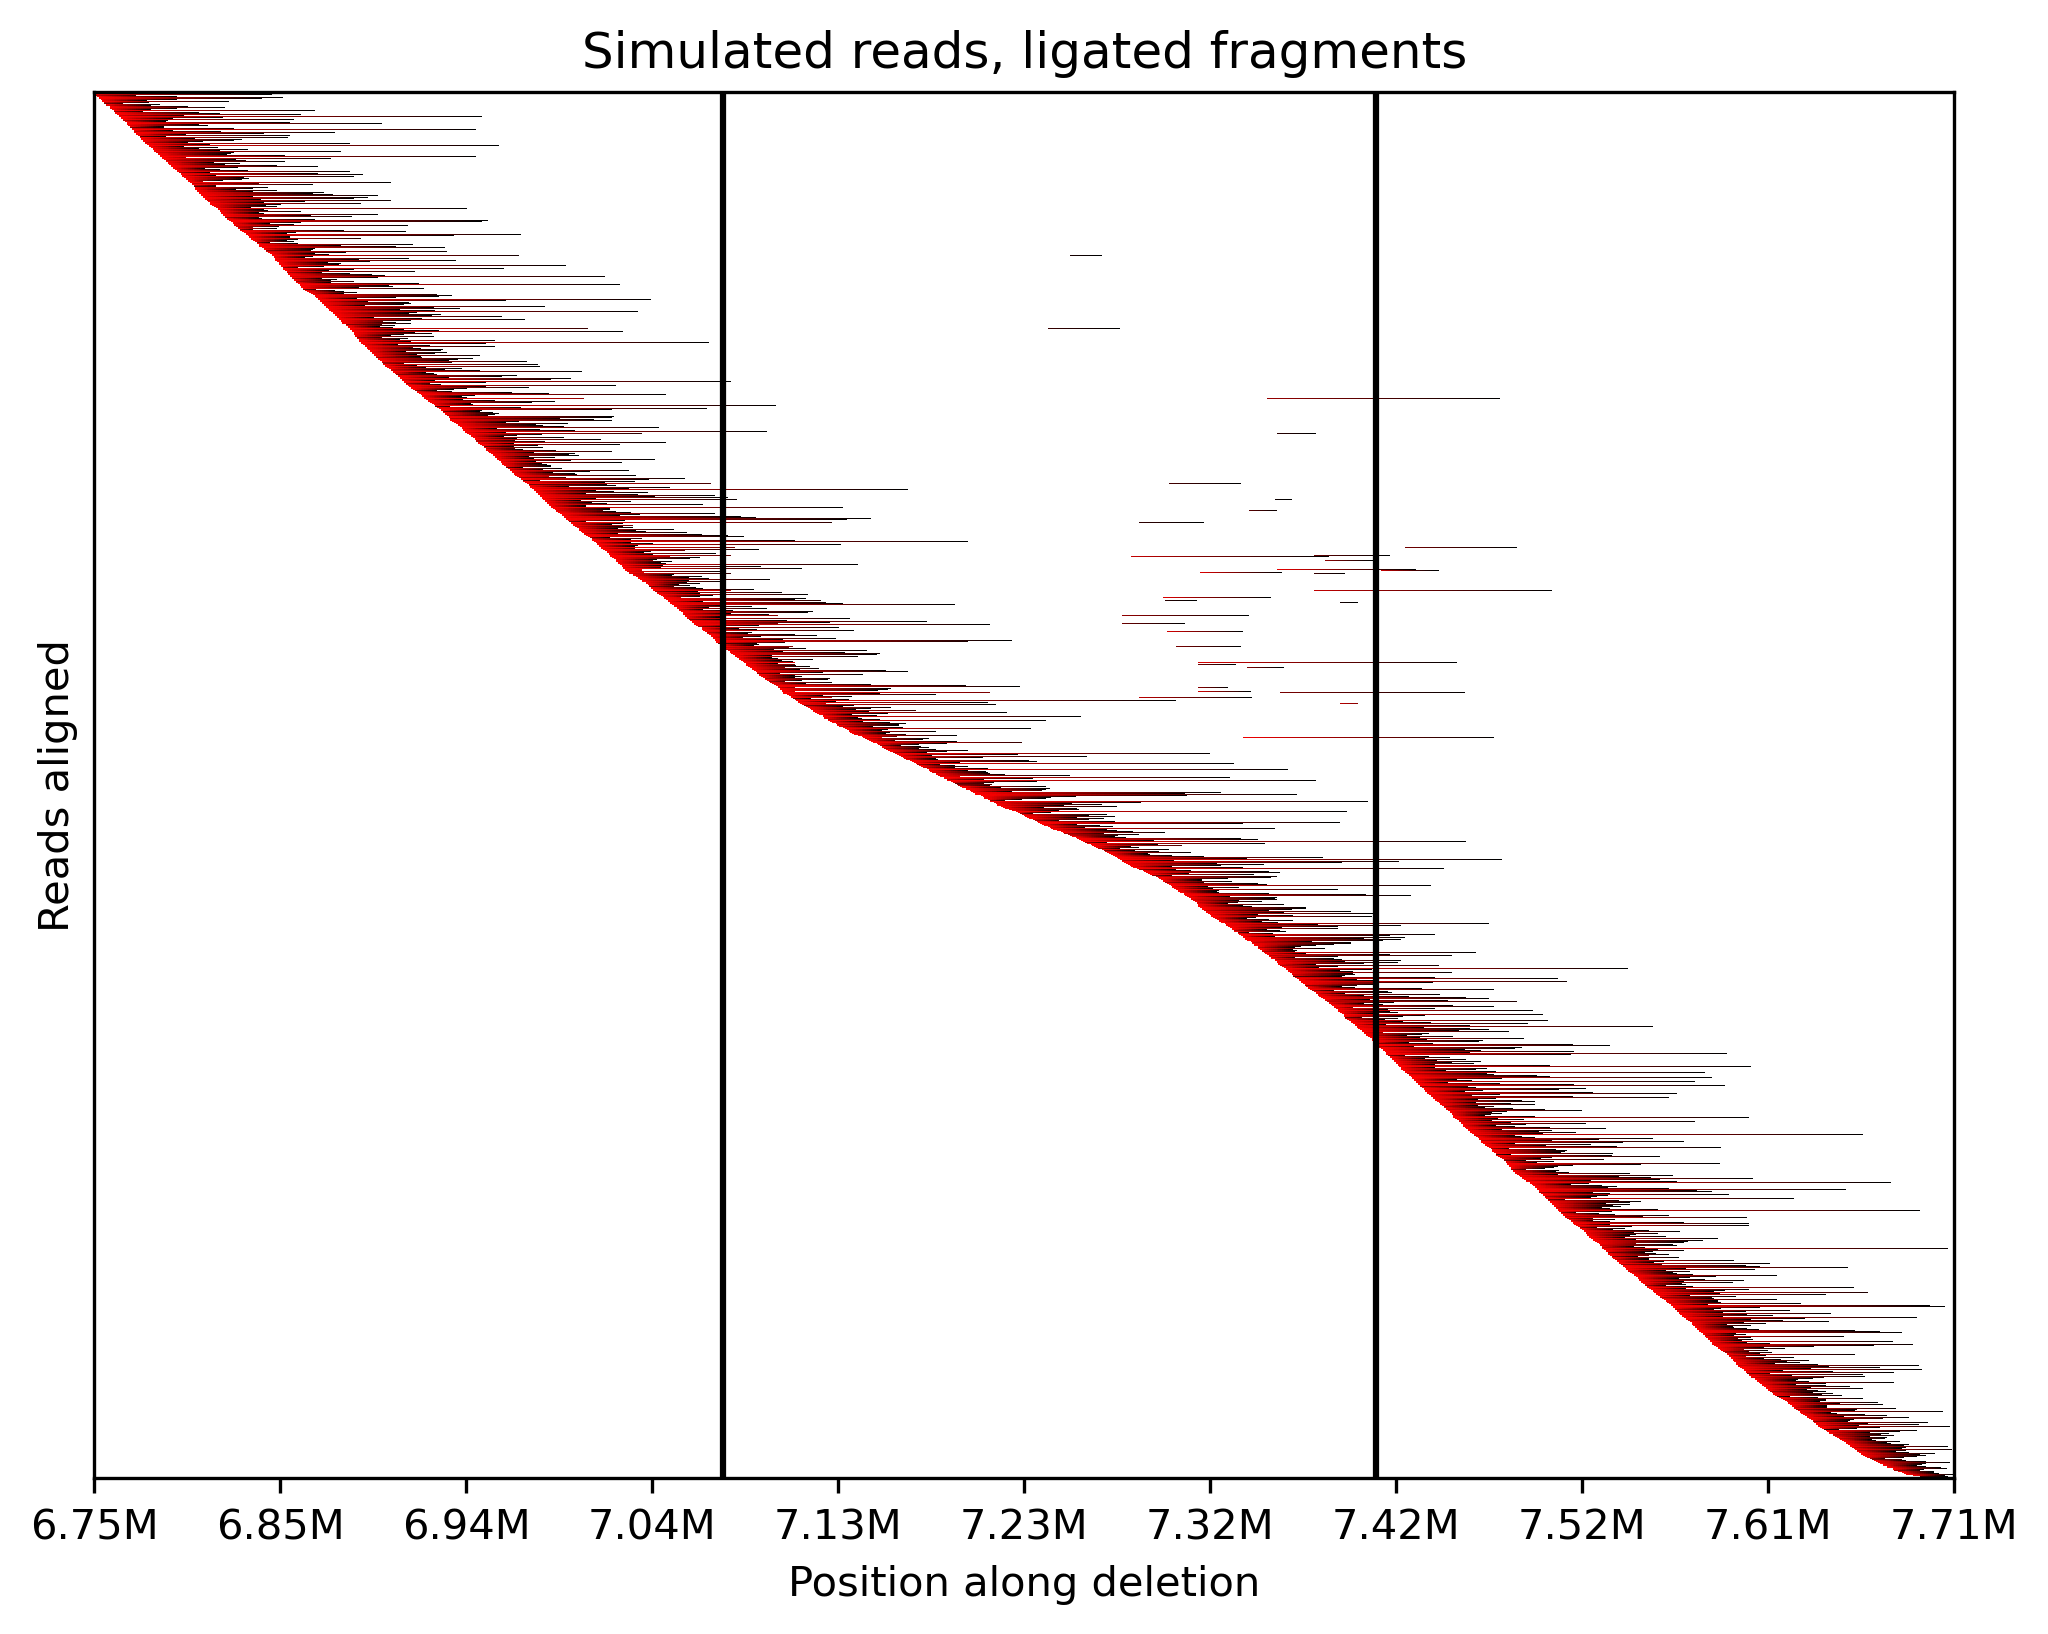

In [24]:
plot_matrix(matrix_sim_reads, figsize=(8,6), title="Simulated reads, ligated fragments")

### Simulated dataset (free fragments - deletion split)

In [25]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.mm2.sorted.bam"
matrix_sim_reads2, reads_idx = read_bam(bamf, sim_reads_sep_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_sim_reads2 = sort_matrix(matrix_sim_reads2)

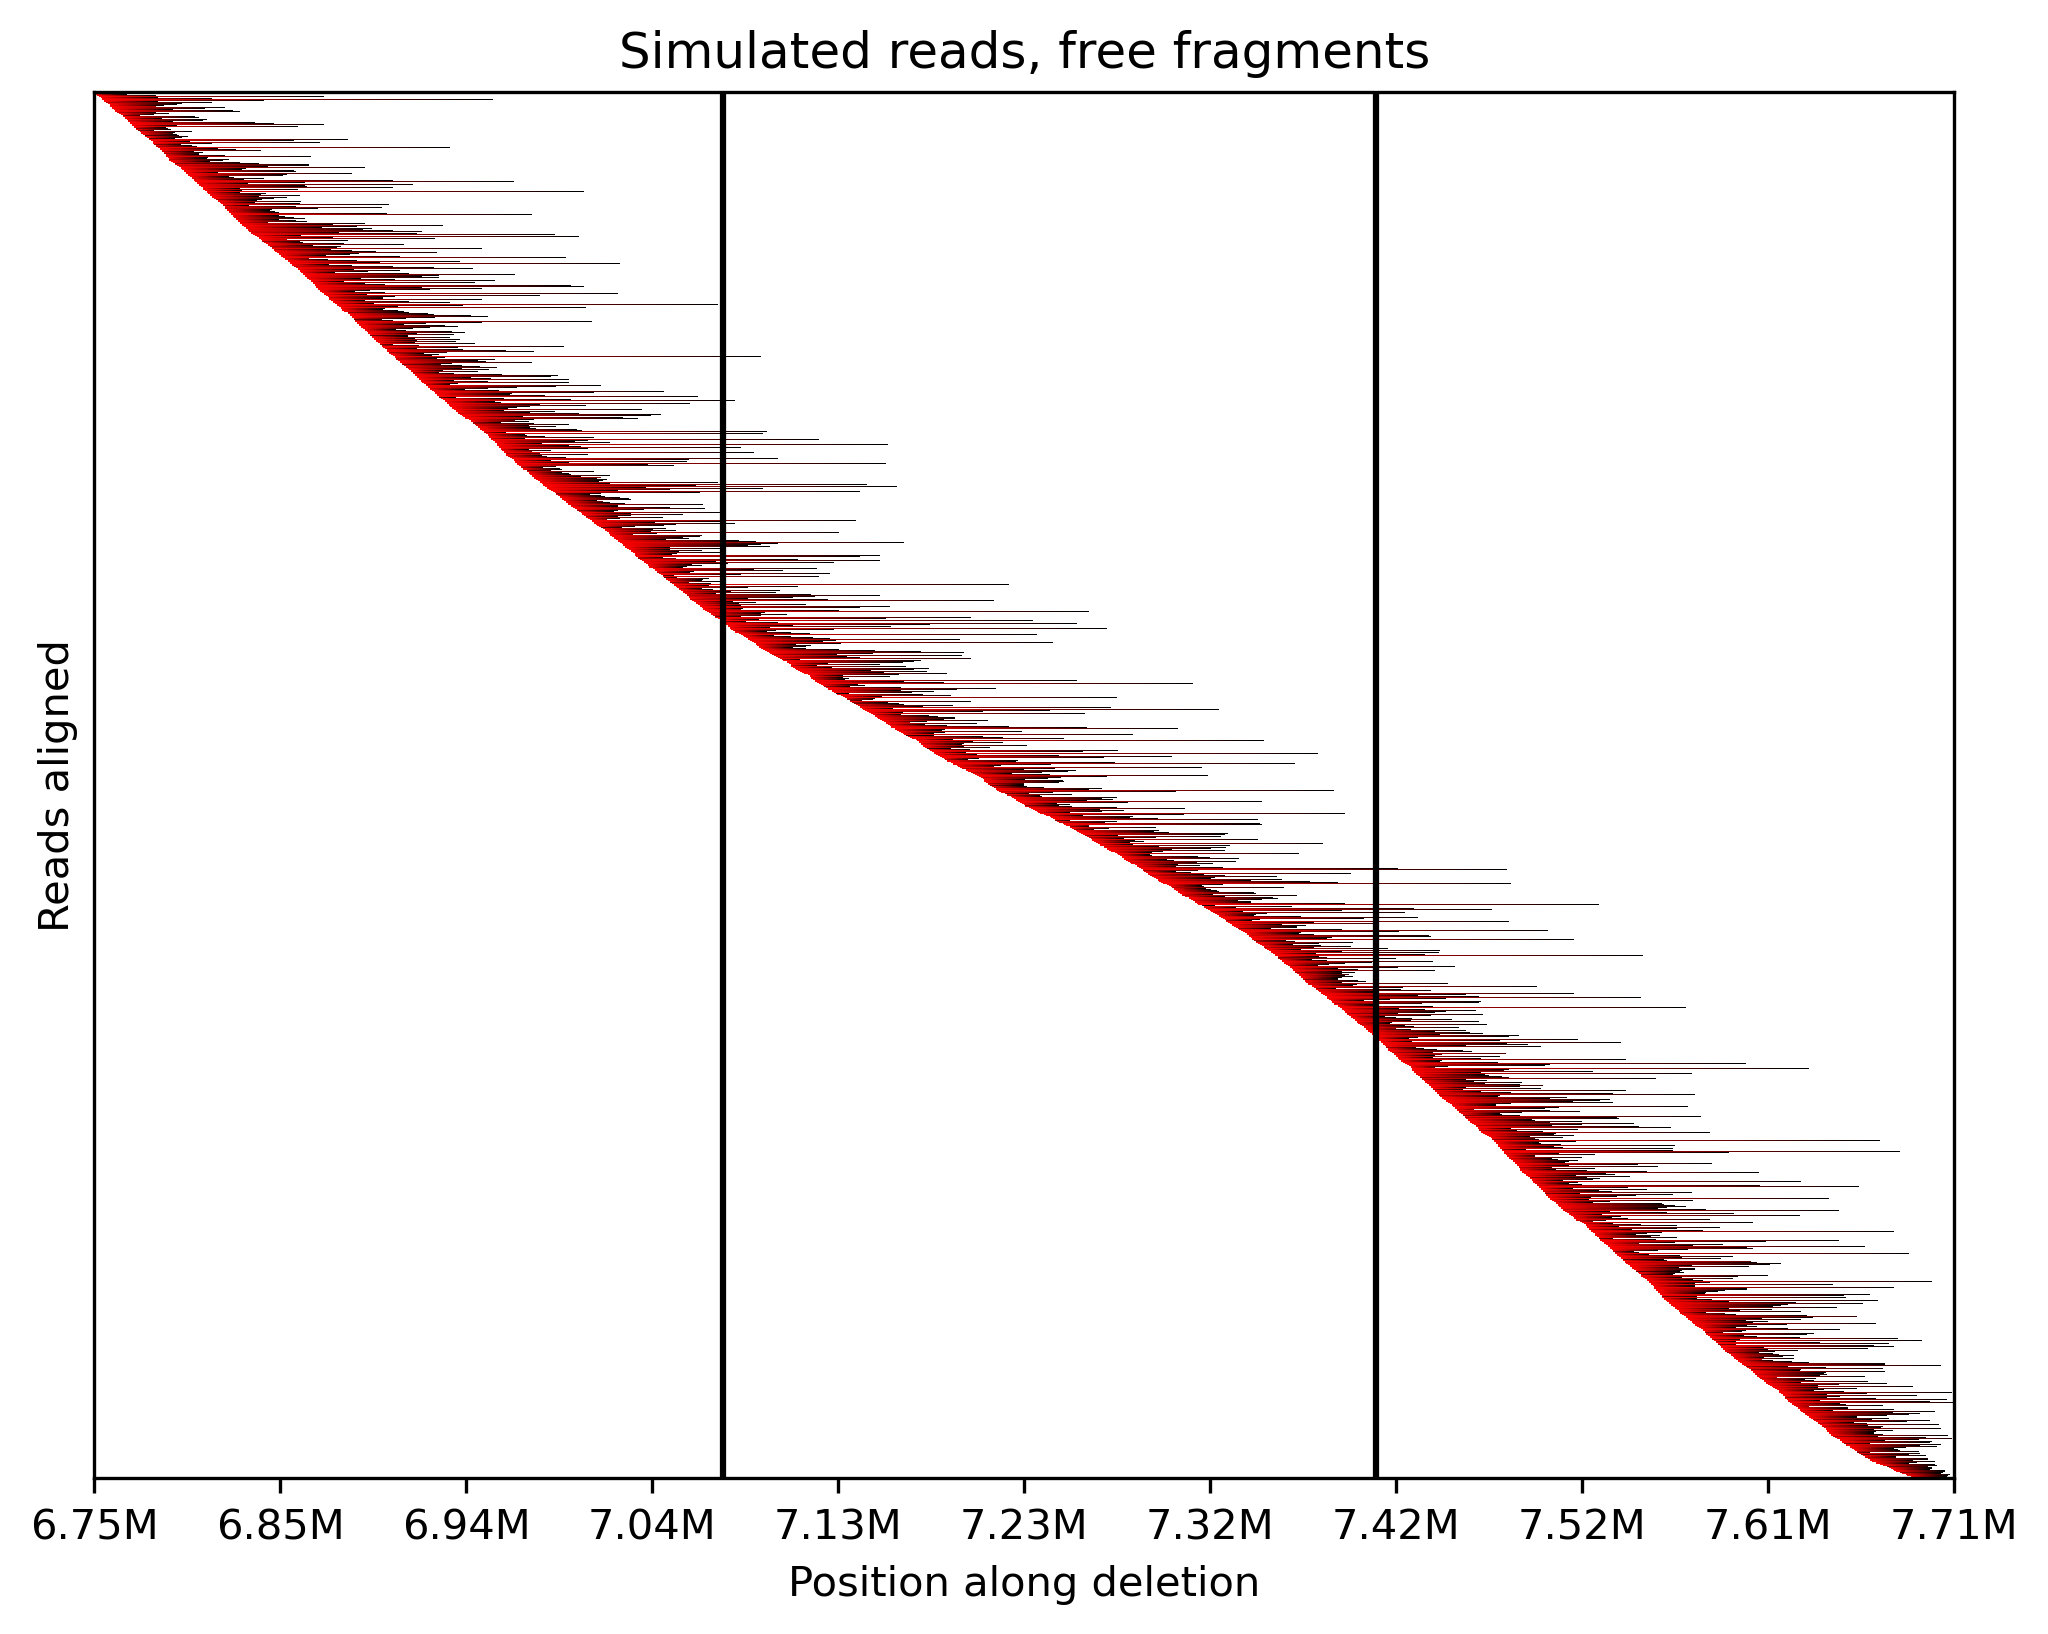

In [26]:
plot_matrix(matrix_sim_reads2, figsize=(8,6), title="Simulated reads, free fragments")

### Combined figure

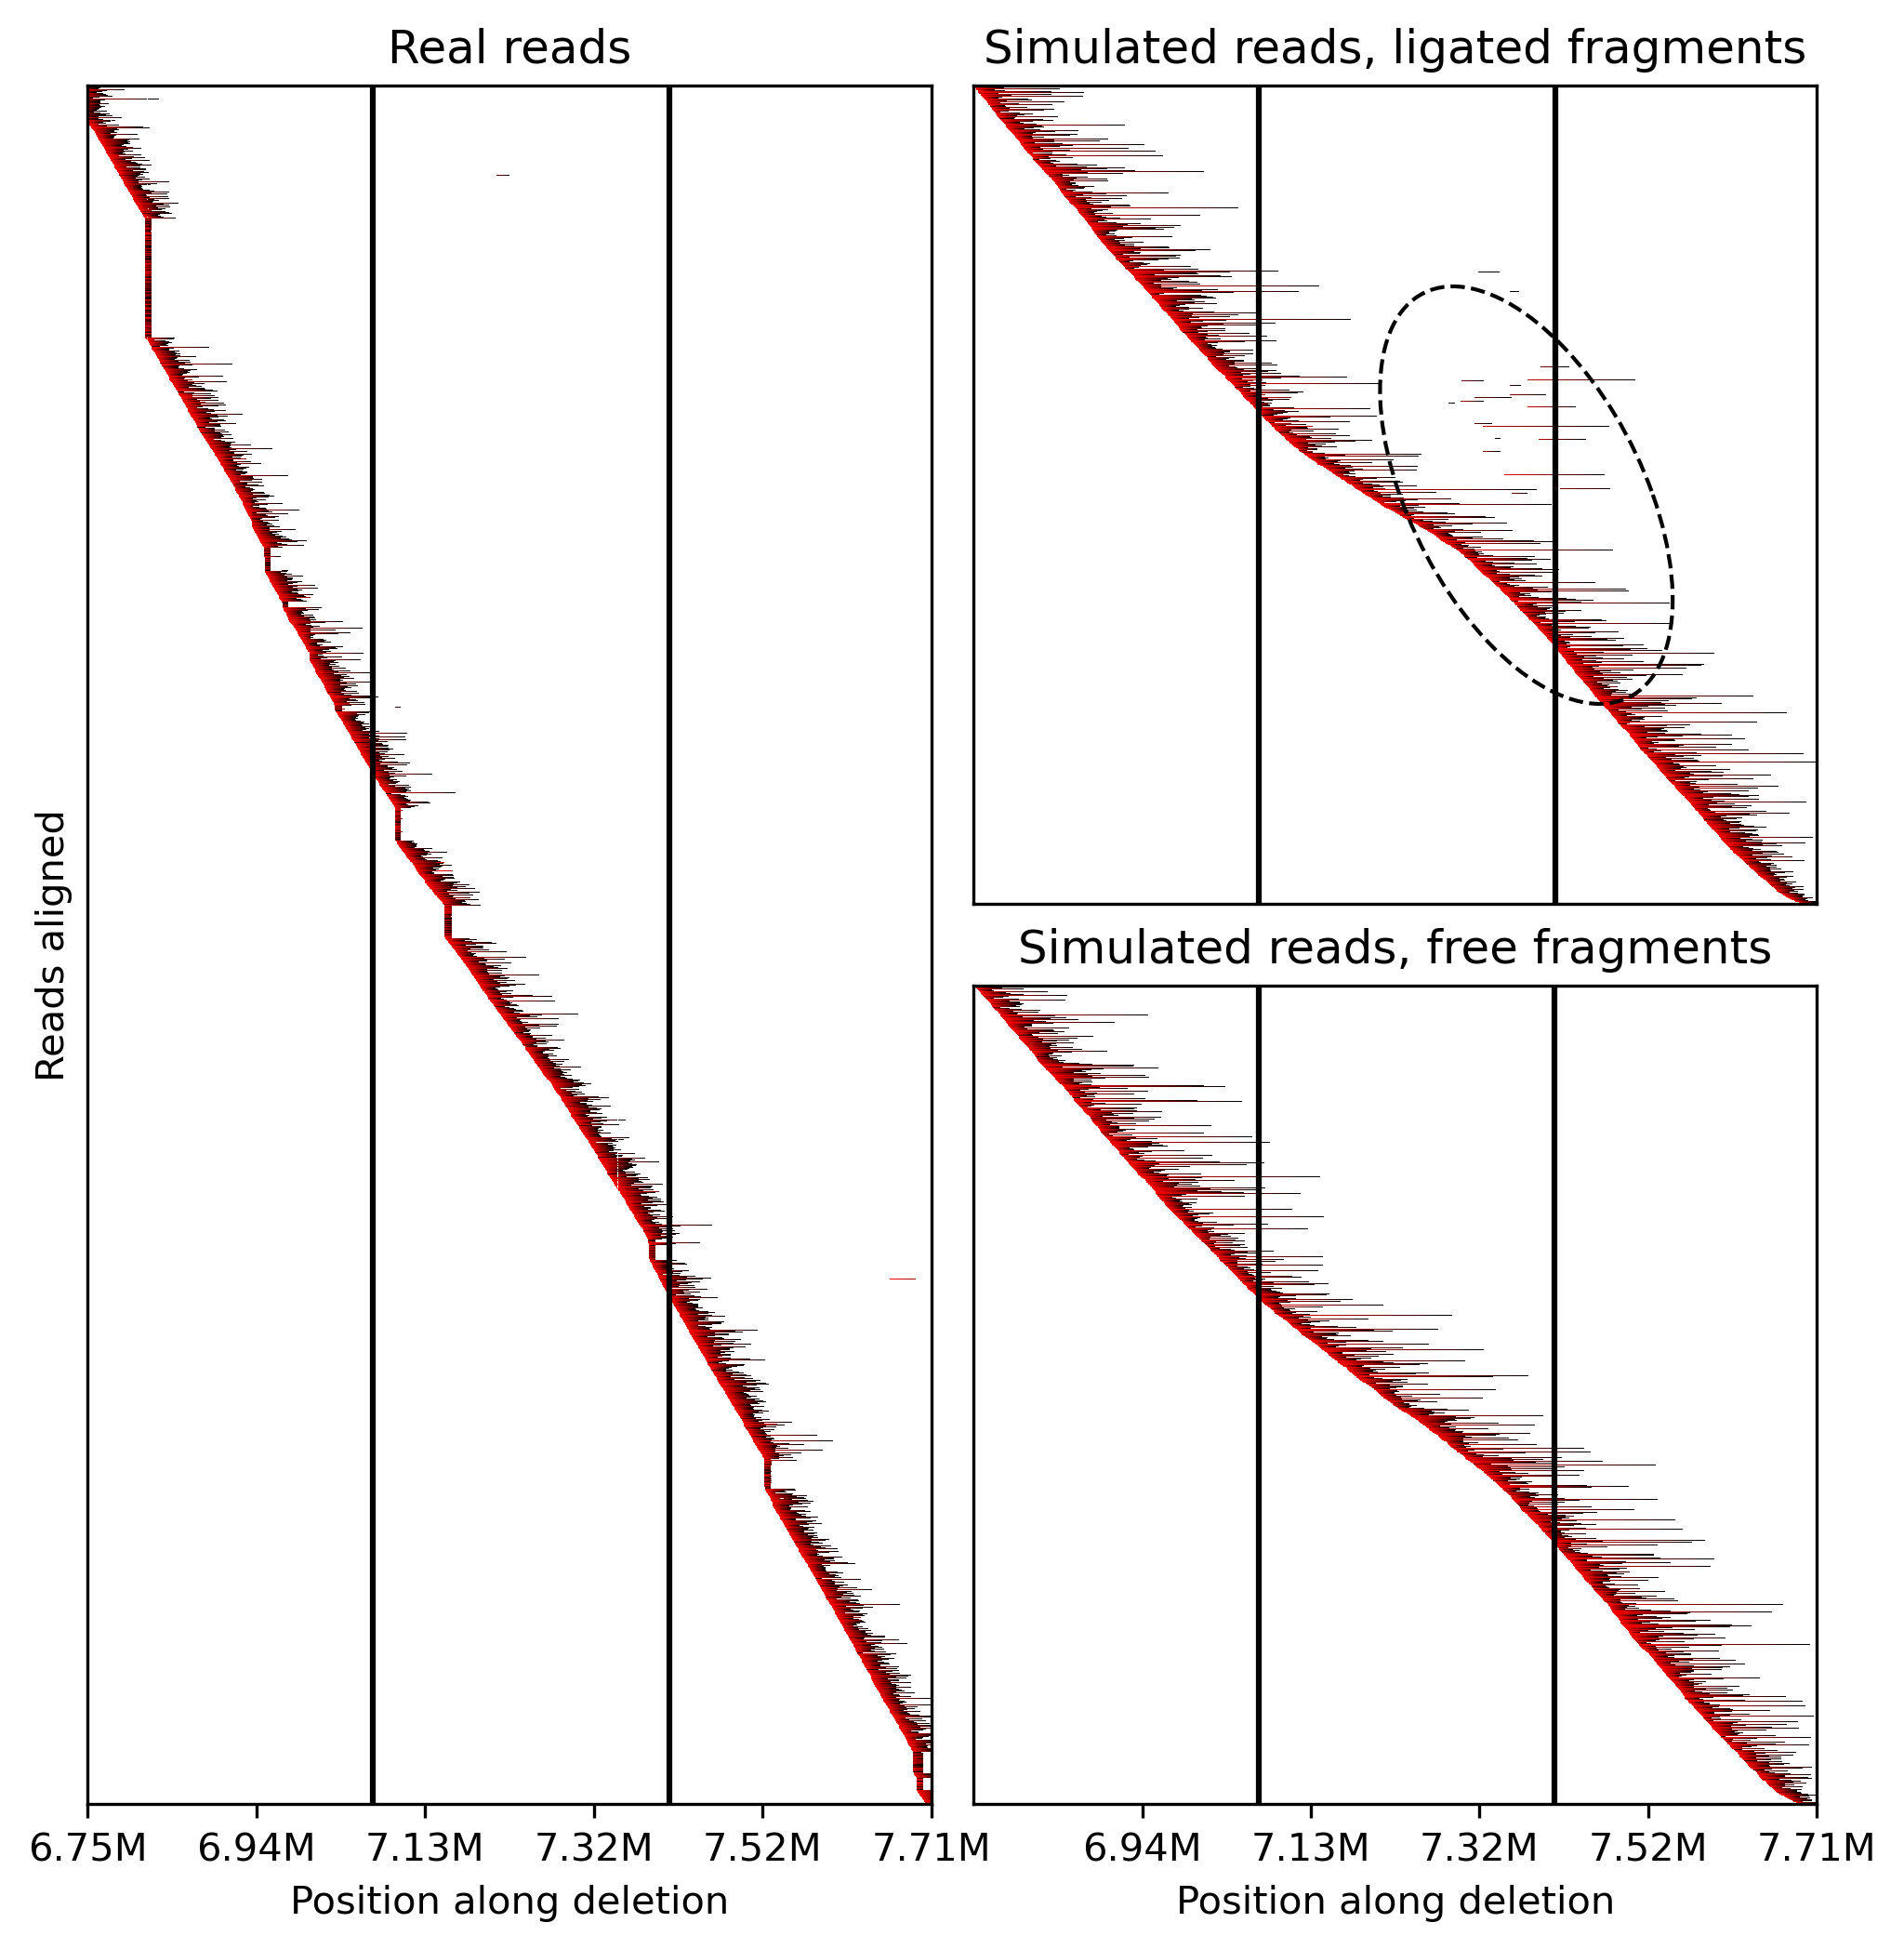

In [27]:
start=6749498
end=7706692
length=957195
delstart=7047000
delend=7383000

cmap = mpl.cm.seismic
colors = [(1, 0, 0), (0, 0, 0)] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=50)
cmap.set_bad(color='white')

fig = plt.figure(figsize=(8,8)) #subplots(nrows=2, ncols=2, figsize=(8,8))

gs = GridSpec(2, 2, figure=fig)
axs = []

# Ax column 0
ax1 = fig.add_subplot(gs[:,0])

masked_array = np.ma.array(matrix_real, mask=np.isnan(matrix_real))
ax1.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax1.set_title("Real reads")
ax1.set_ylabel("Reads aligned")

# Ax 0,1
ax2 = fig.add_subplot(gs[0,1])

masked_array = np.ma.array (matrix_sim_reads, mask=np.isnan(matrix_sim_reads))
ax2.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax2.set_title("Simulated reads, ligated fragments")

# Ax 1,1
ax3 = fig.add_subplot(gs[1,1])

masked_array = np.ma.array (matrix_sim_reads2, mask=np.isnan(matrix_sim_reads2))
ax3.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax3.set_title("Simulated reads, free fragments")


for ax in [ax1,ax2,ax3] :
    ax.tick_params(axis="y", length=0)
    ax.set_yticks([])
    
    plot_del_start = int( ((end - delstart) / length)*1000 )
    plot_del_end = int( ((end - delend) / length)*1000 )
    ax.axvline(plot_del_start, 0, 1, color="k") , #plot_del_end], ymin=0, ymax=len(matrix), color="k", zorder=10)
    ax.axvline(plot_del_end, 0, 1, color="k")

for ax in [ax1,ax3] :
    ax.set_xlabel("Position along deletion")
    ax.set_xlim(0,1000)
    
ax2.set_xticks([])

xticks = np.arange(0, 1001, 200)
ax1.set_xticks(xticks)
ax1.set_xticklabels(["{:.2f}M".format( (start + int((i*(length/1000))))/1e6 ) for i in xticks])

ax3.set_xticks(xticks[1:])
ax3.set_xticklabels(["{:.2f}M".format( (start + int((i*(length/1000))))/1e6 ) for i in xticks[1:]])

el = patches.Ellipse(
    (655, 4900), 5000, 300, angle=88,
    linewidth=1.0, fill=False, color="k", linestyle="dashed", zorder=15
)
ax2.add_patch(el)

#el = patches.Ellipse(
#    (630, 5000), 5000, 300, angle=88,
#    linewidth=1.0, fill=False, color="r", linestyle="dashed", zorder=15
#)
#ax2.add_patch(el)

fig.subplots_adjust(wspace=0.05, hspace=0.1)

plt.show()

# 2. Minimap2 -ax splice -G400k

### Real dataset

In [9]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/real_v_del.mm2_splice.sorted.bam"
matrix_real, reads_idx = read_bam(bamf, real_reads_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_real = sort_matrix(matrix_real)

#### Given an array of values and NaNs, sort the arrays by starting position of the longest cluster of non-NaN values

In [10]:
def get_start(arr) :
    #print(read)
    # Initialize variables to track current cluster of non-nan values
    start_pos = None
    stop_pos = None

    # Initialize list to store results
    max_start = None
    max_length = None

    # Loop over elements of input array
    for i in range(len(arr)):
        if not np.isnan(arr[i]): # Check if current element is non-nan
            stop_pos = i # Update stop position of current cluster
            if start_pos is None: # If start position is not set yet, update it
                start_pos = i

        elif start_pos is not None: # Check if current element is nan and the current cluster is non-empty
            # Add start position, stop position, and length of current cluster to results
            length = stop_pos - start_pos + 1
            if max_length is None or length > max_length :
                max_length = length
                max_start = start_pos

            # Reset start position and stop position for new cluster
            start_pos = None
            stop_pos = None

    # Check if there is an open cluster at the end of the array
    if start_pos is not None:
        length = stop_pos - start_pos + 1
        if max_length is None or length > max_length :
            max_length = length
            max_start = start_pos

        # Reset start position and stop position for new cluster
        start_pos = None
        stop_pos = None
    
    if max_start is None :
        return 0
    else :
        return max_start

In [11]:
start_values = np.apply_along_axis(get_start, axis=1, arr=matrix_real)
sorted_indices = [i for i, x in sorted(enumerate(start_values), key=lambda x: x[1])]

In [12]:
matrix_real_sorted_by_start = [matrix_real[i] for i in sorted_indices]

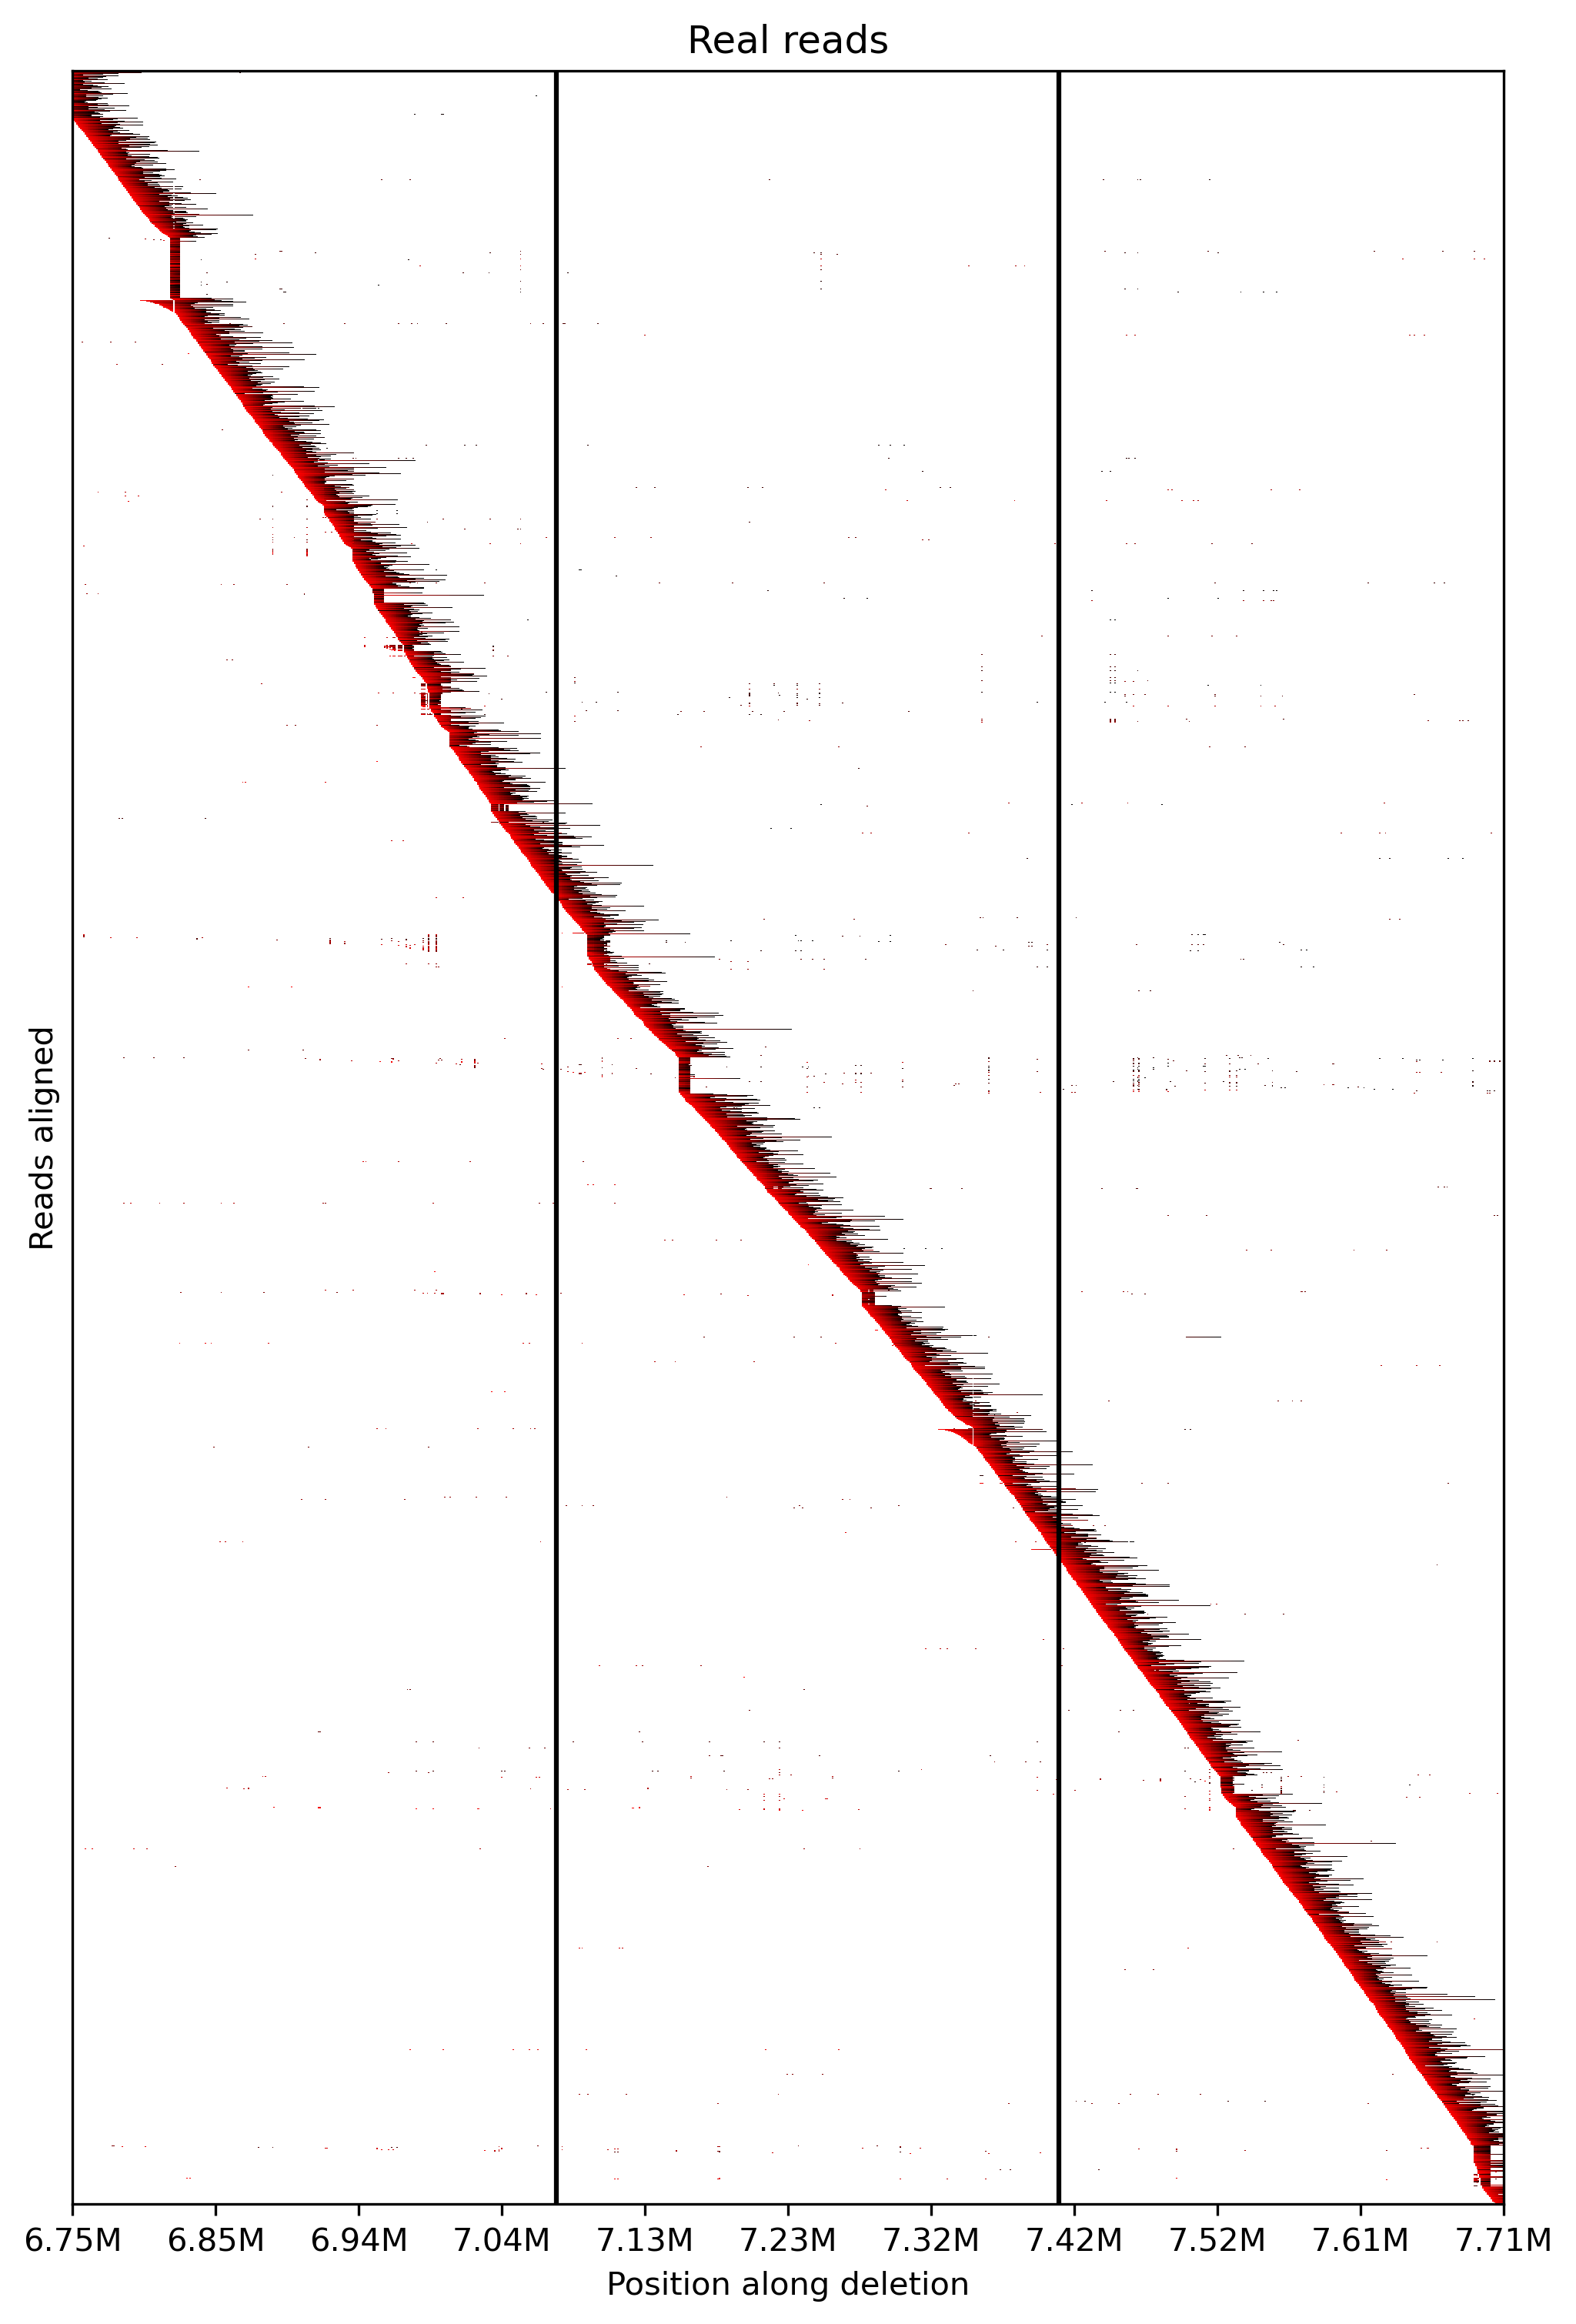

In [13]:
plot_matrix(matrix_real_sorted_by_start, figsize=(8,12), title="Real reads")

### Simulated dataset (round 2, no free fragments - deletion merged)

In [14]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_merged_v_del_round2.mm2_splice.sorted.bam"
matrix_sim_reads, reads_idx = read_bam(bamf, sim_reads_merged_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)

In [15]:
start_values = np.apply_along_axis(get_start, axis=1, arr=matrix_sim_reads)
sorted_indices = [i for i, x in sorted(enumerate(start_values), key=lambda x: x[1])]
matrix_sim_reads_sorted_by_start = [matrix_sim_reads[i] for i in sorted_indices]

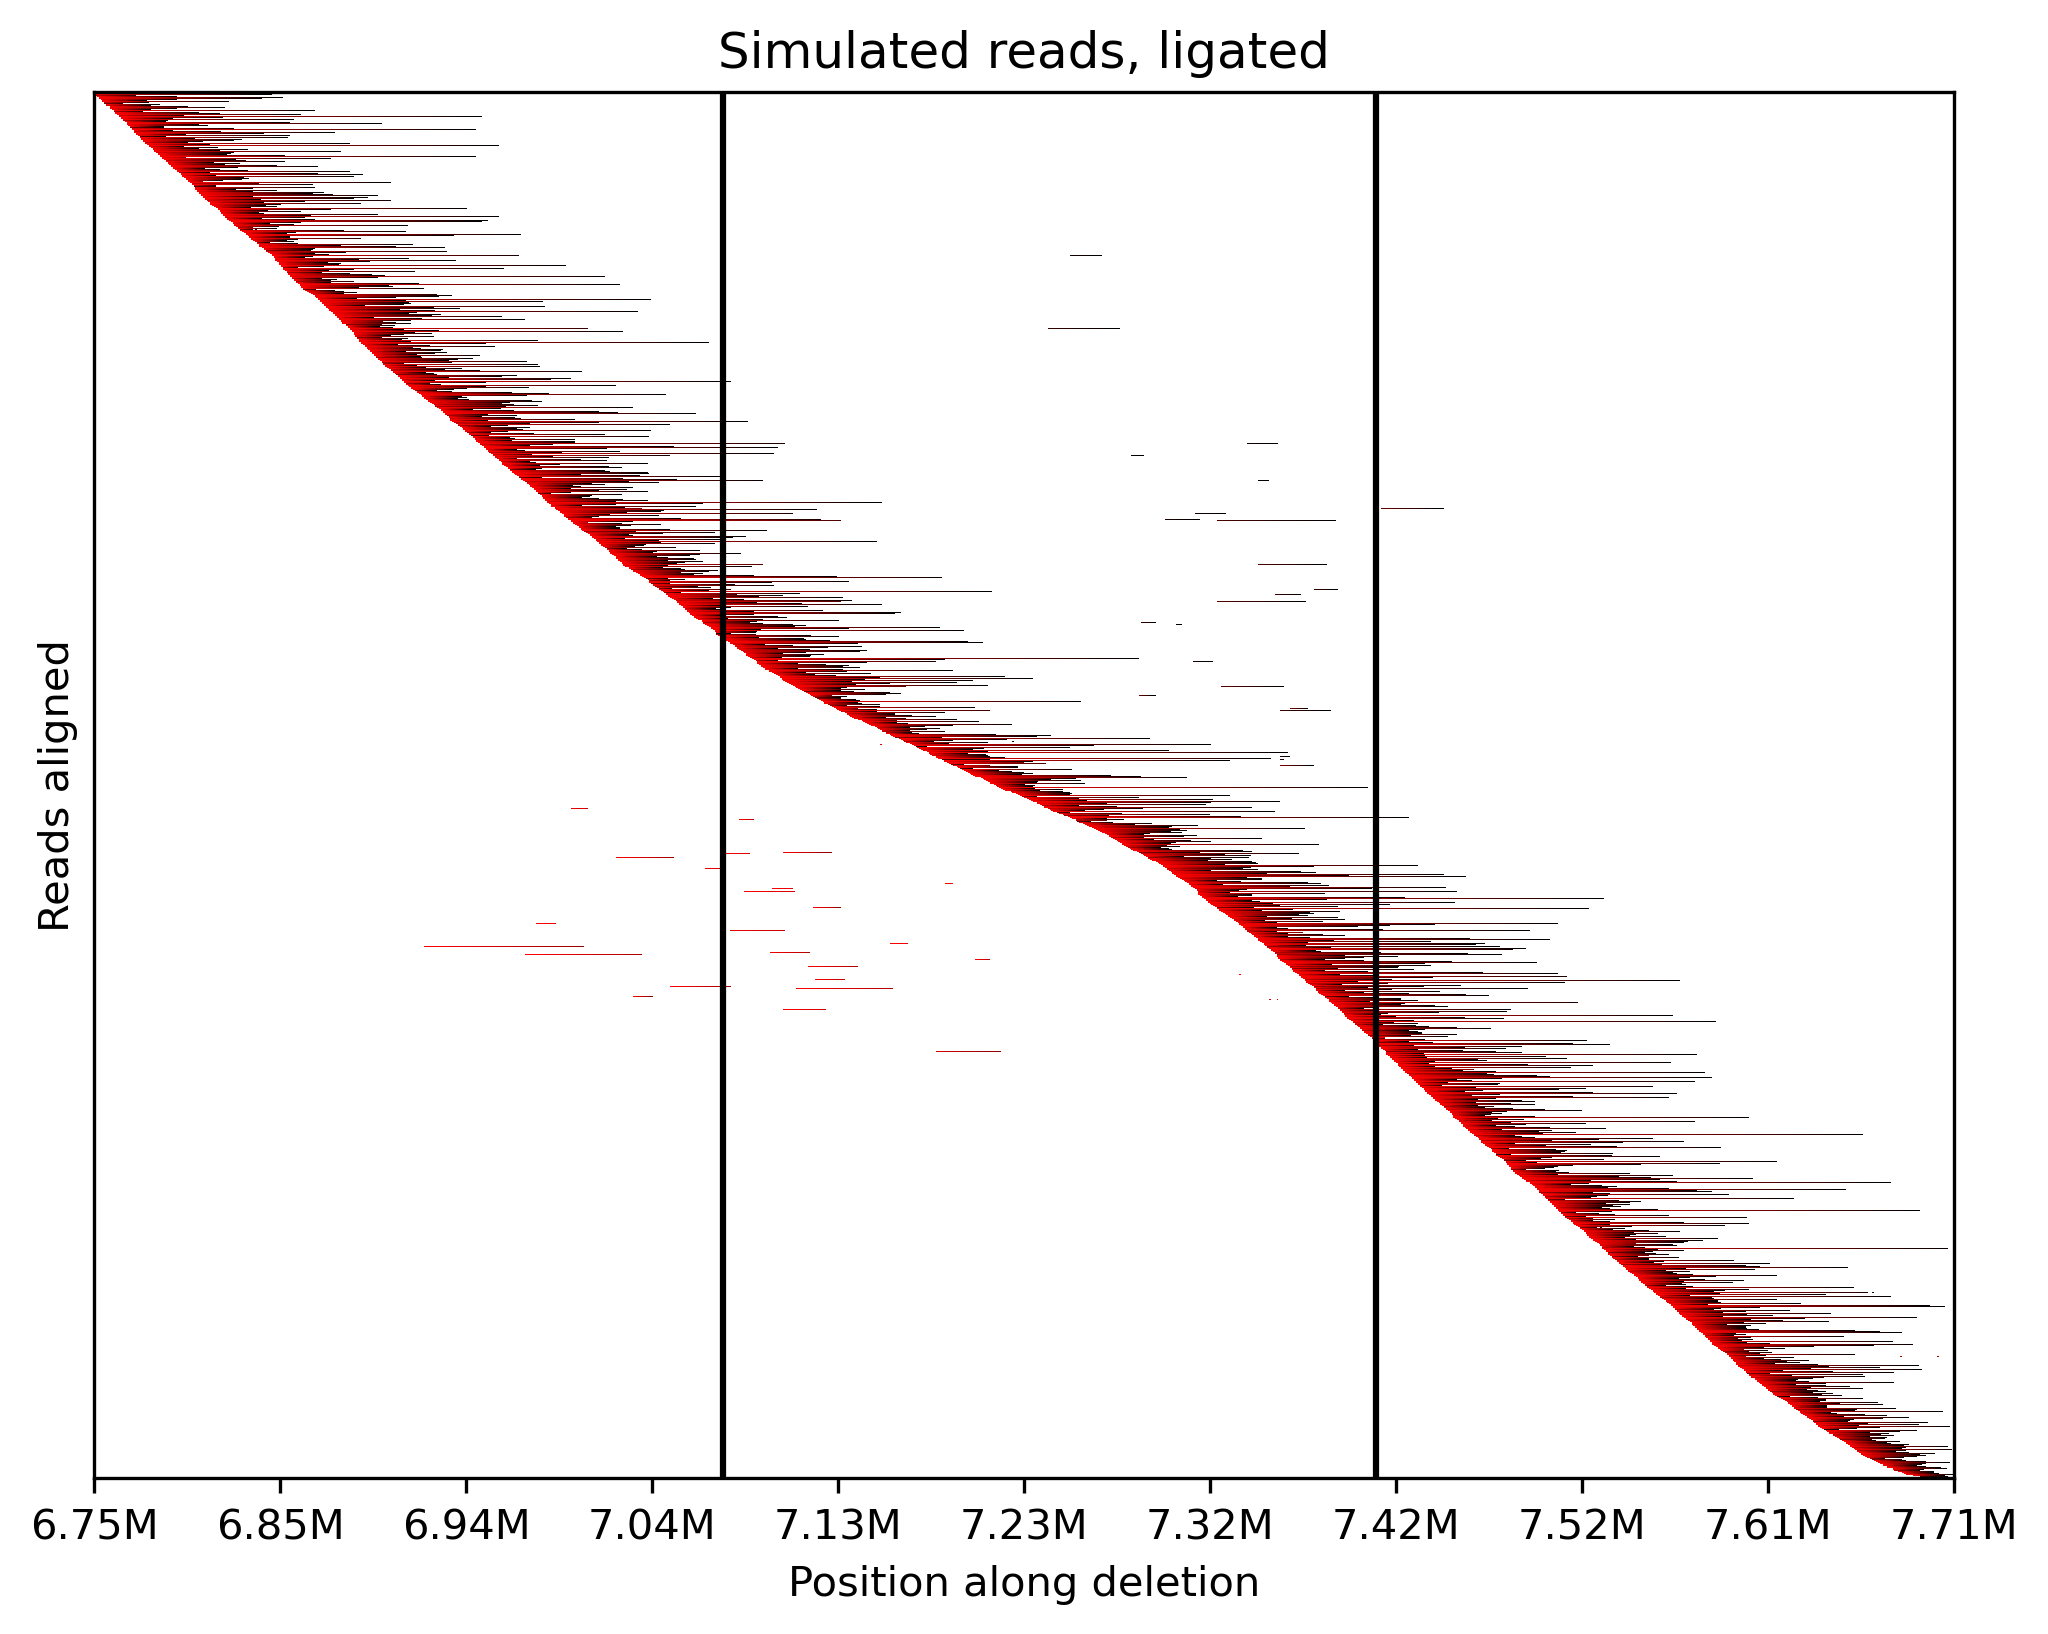

In [16]:
plot_matrix(matrix_sim_reads_sorted_by_start, figsize=(8,6), title="Simulated reads, ligated")

### Simulated dataset (free fragments - deletion split)

In [17]:
bamf = "/media/urbe/MyCDrive1/Antoine/2023-02-13_ARC_ONT_simulation_deletion/sim_sep_v_del_round2.mm2_splice.sorted.bam"
matrix_sim_reads2, reads_idx = read_bam(bamf, sim_reads_sep_length, length, "Chrom_1:6749498-7706692", 0, 7706692-6749498)
smatrix_sim_reads2 = sort_matrix(matrix_sim_reads2)

In [18]:
start_values = np.apply_along_axis(get_start, axis=1, arr=matrix_sim_reads2)
sorted_indices = [i for i, x in sorted(enumerate(start_values), key=lambda x: x[1])]
matrix_sim_reads2_sorted_by_start = [matrix_sim_reads2[i] for i in sorted_indices]

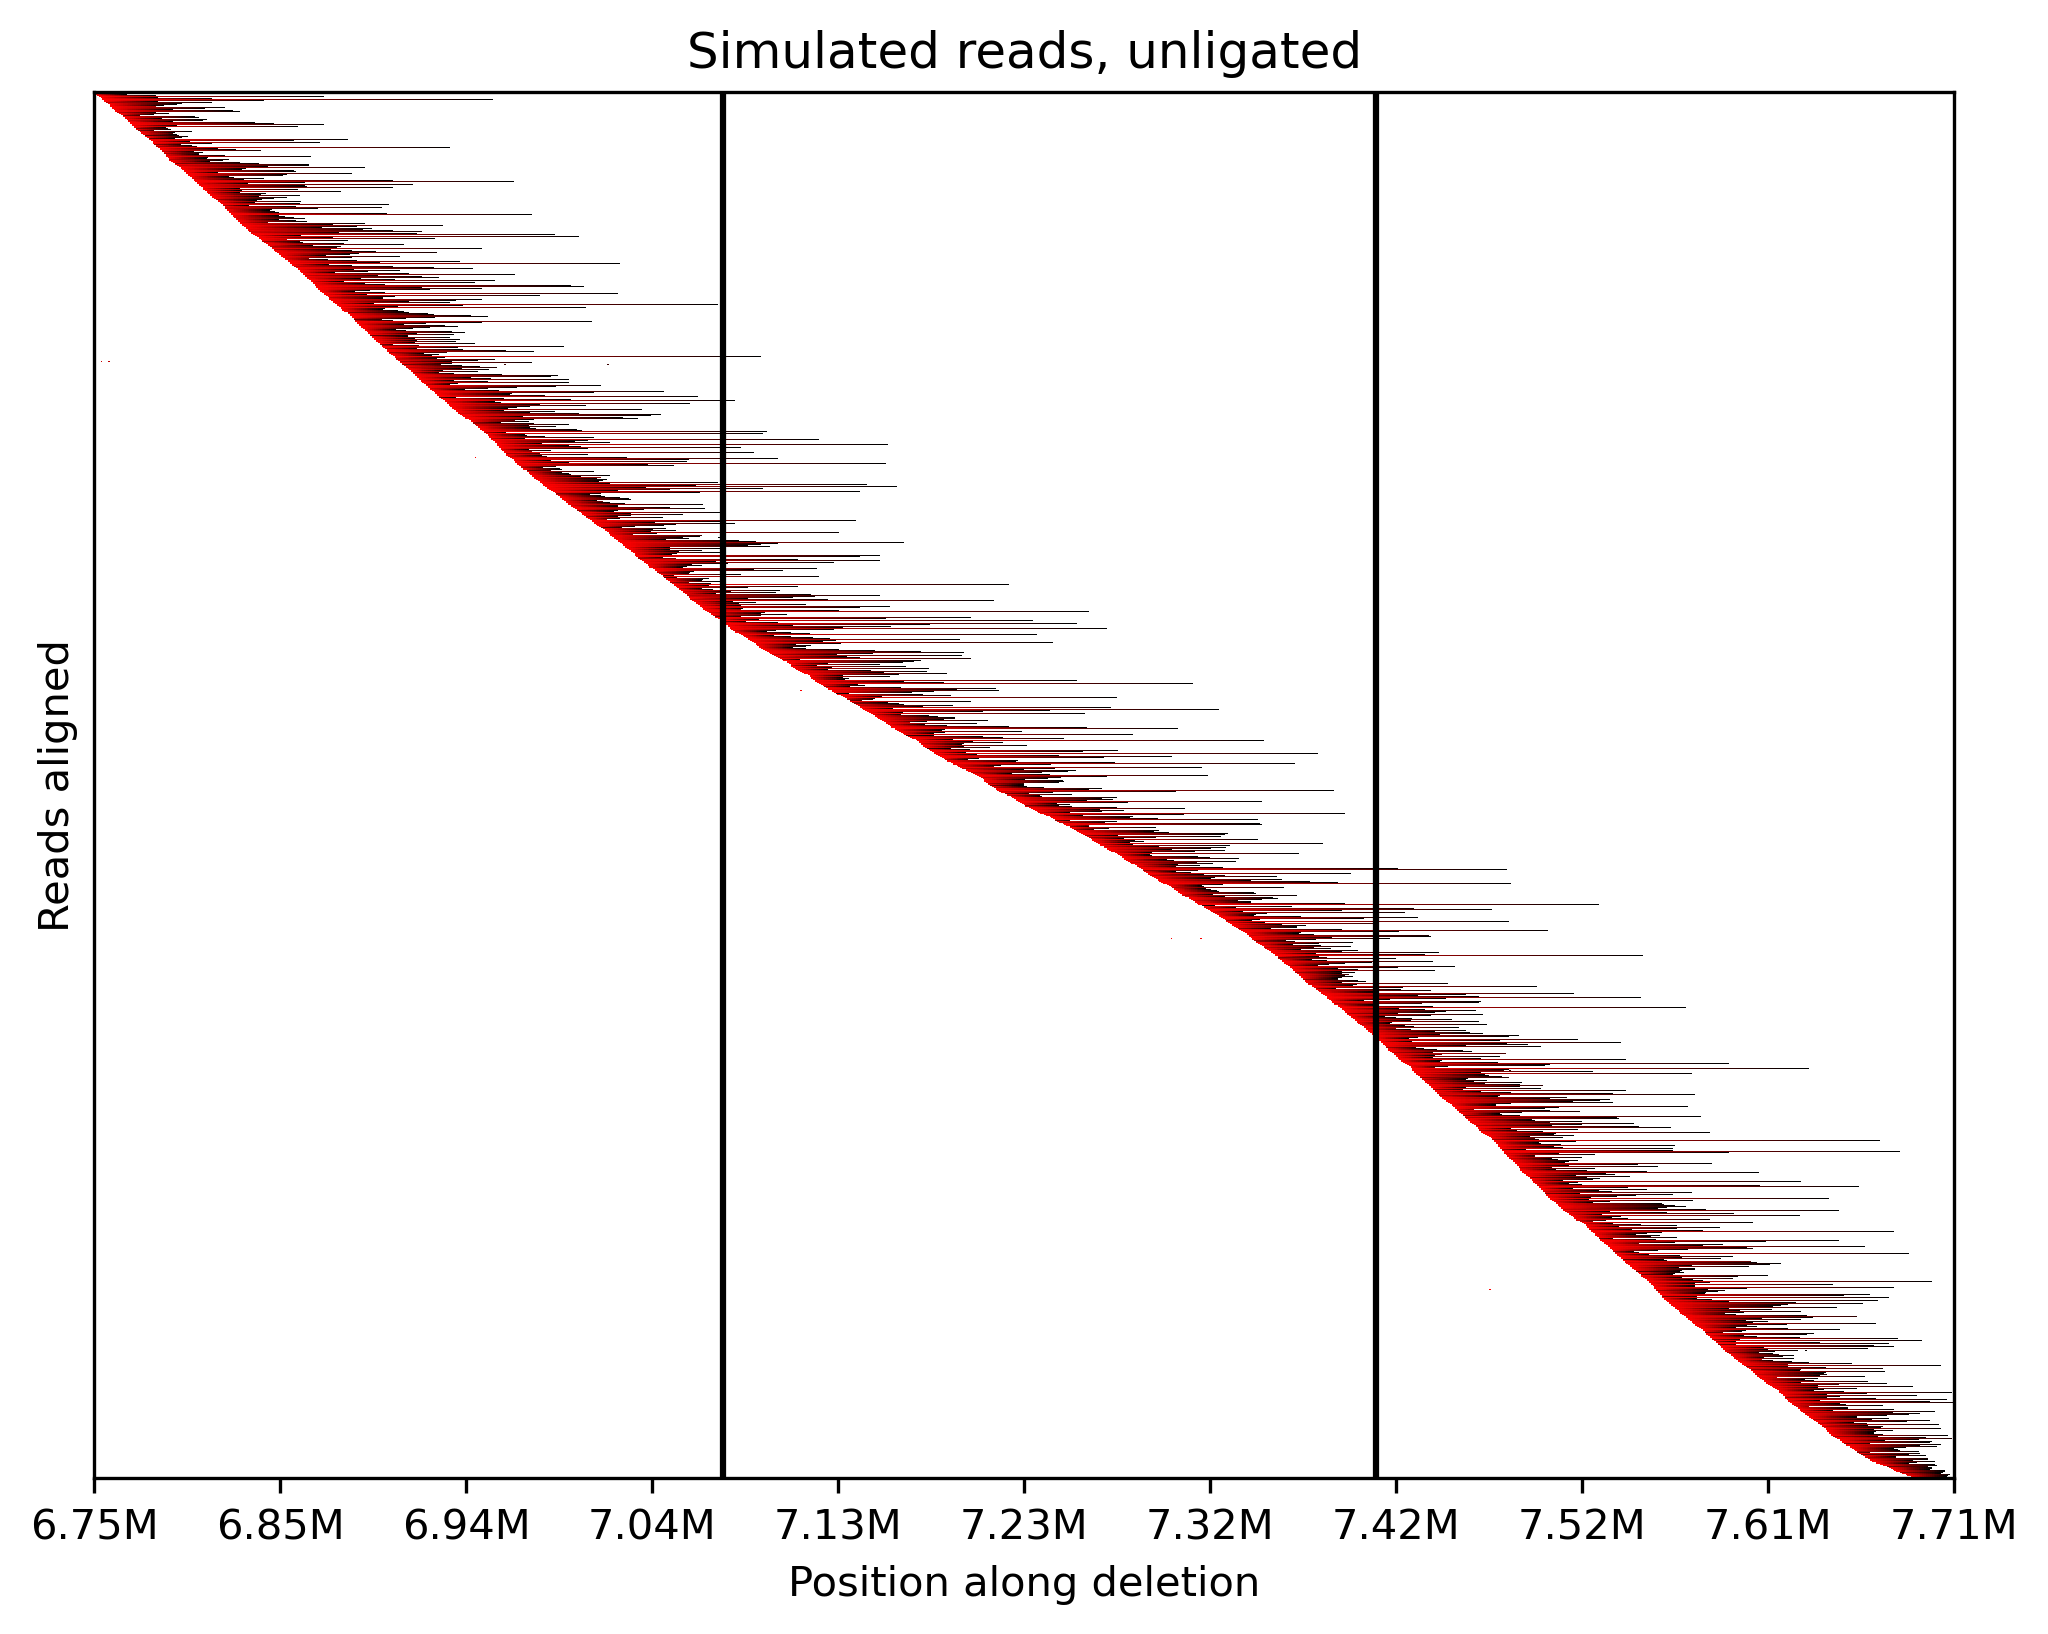

In [19]:
plot_matrix(matrix_sim_reads2_sorted_by_start, figsize=(8,6), title="Simulated reads, unligated")

### Combined figure

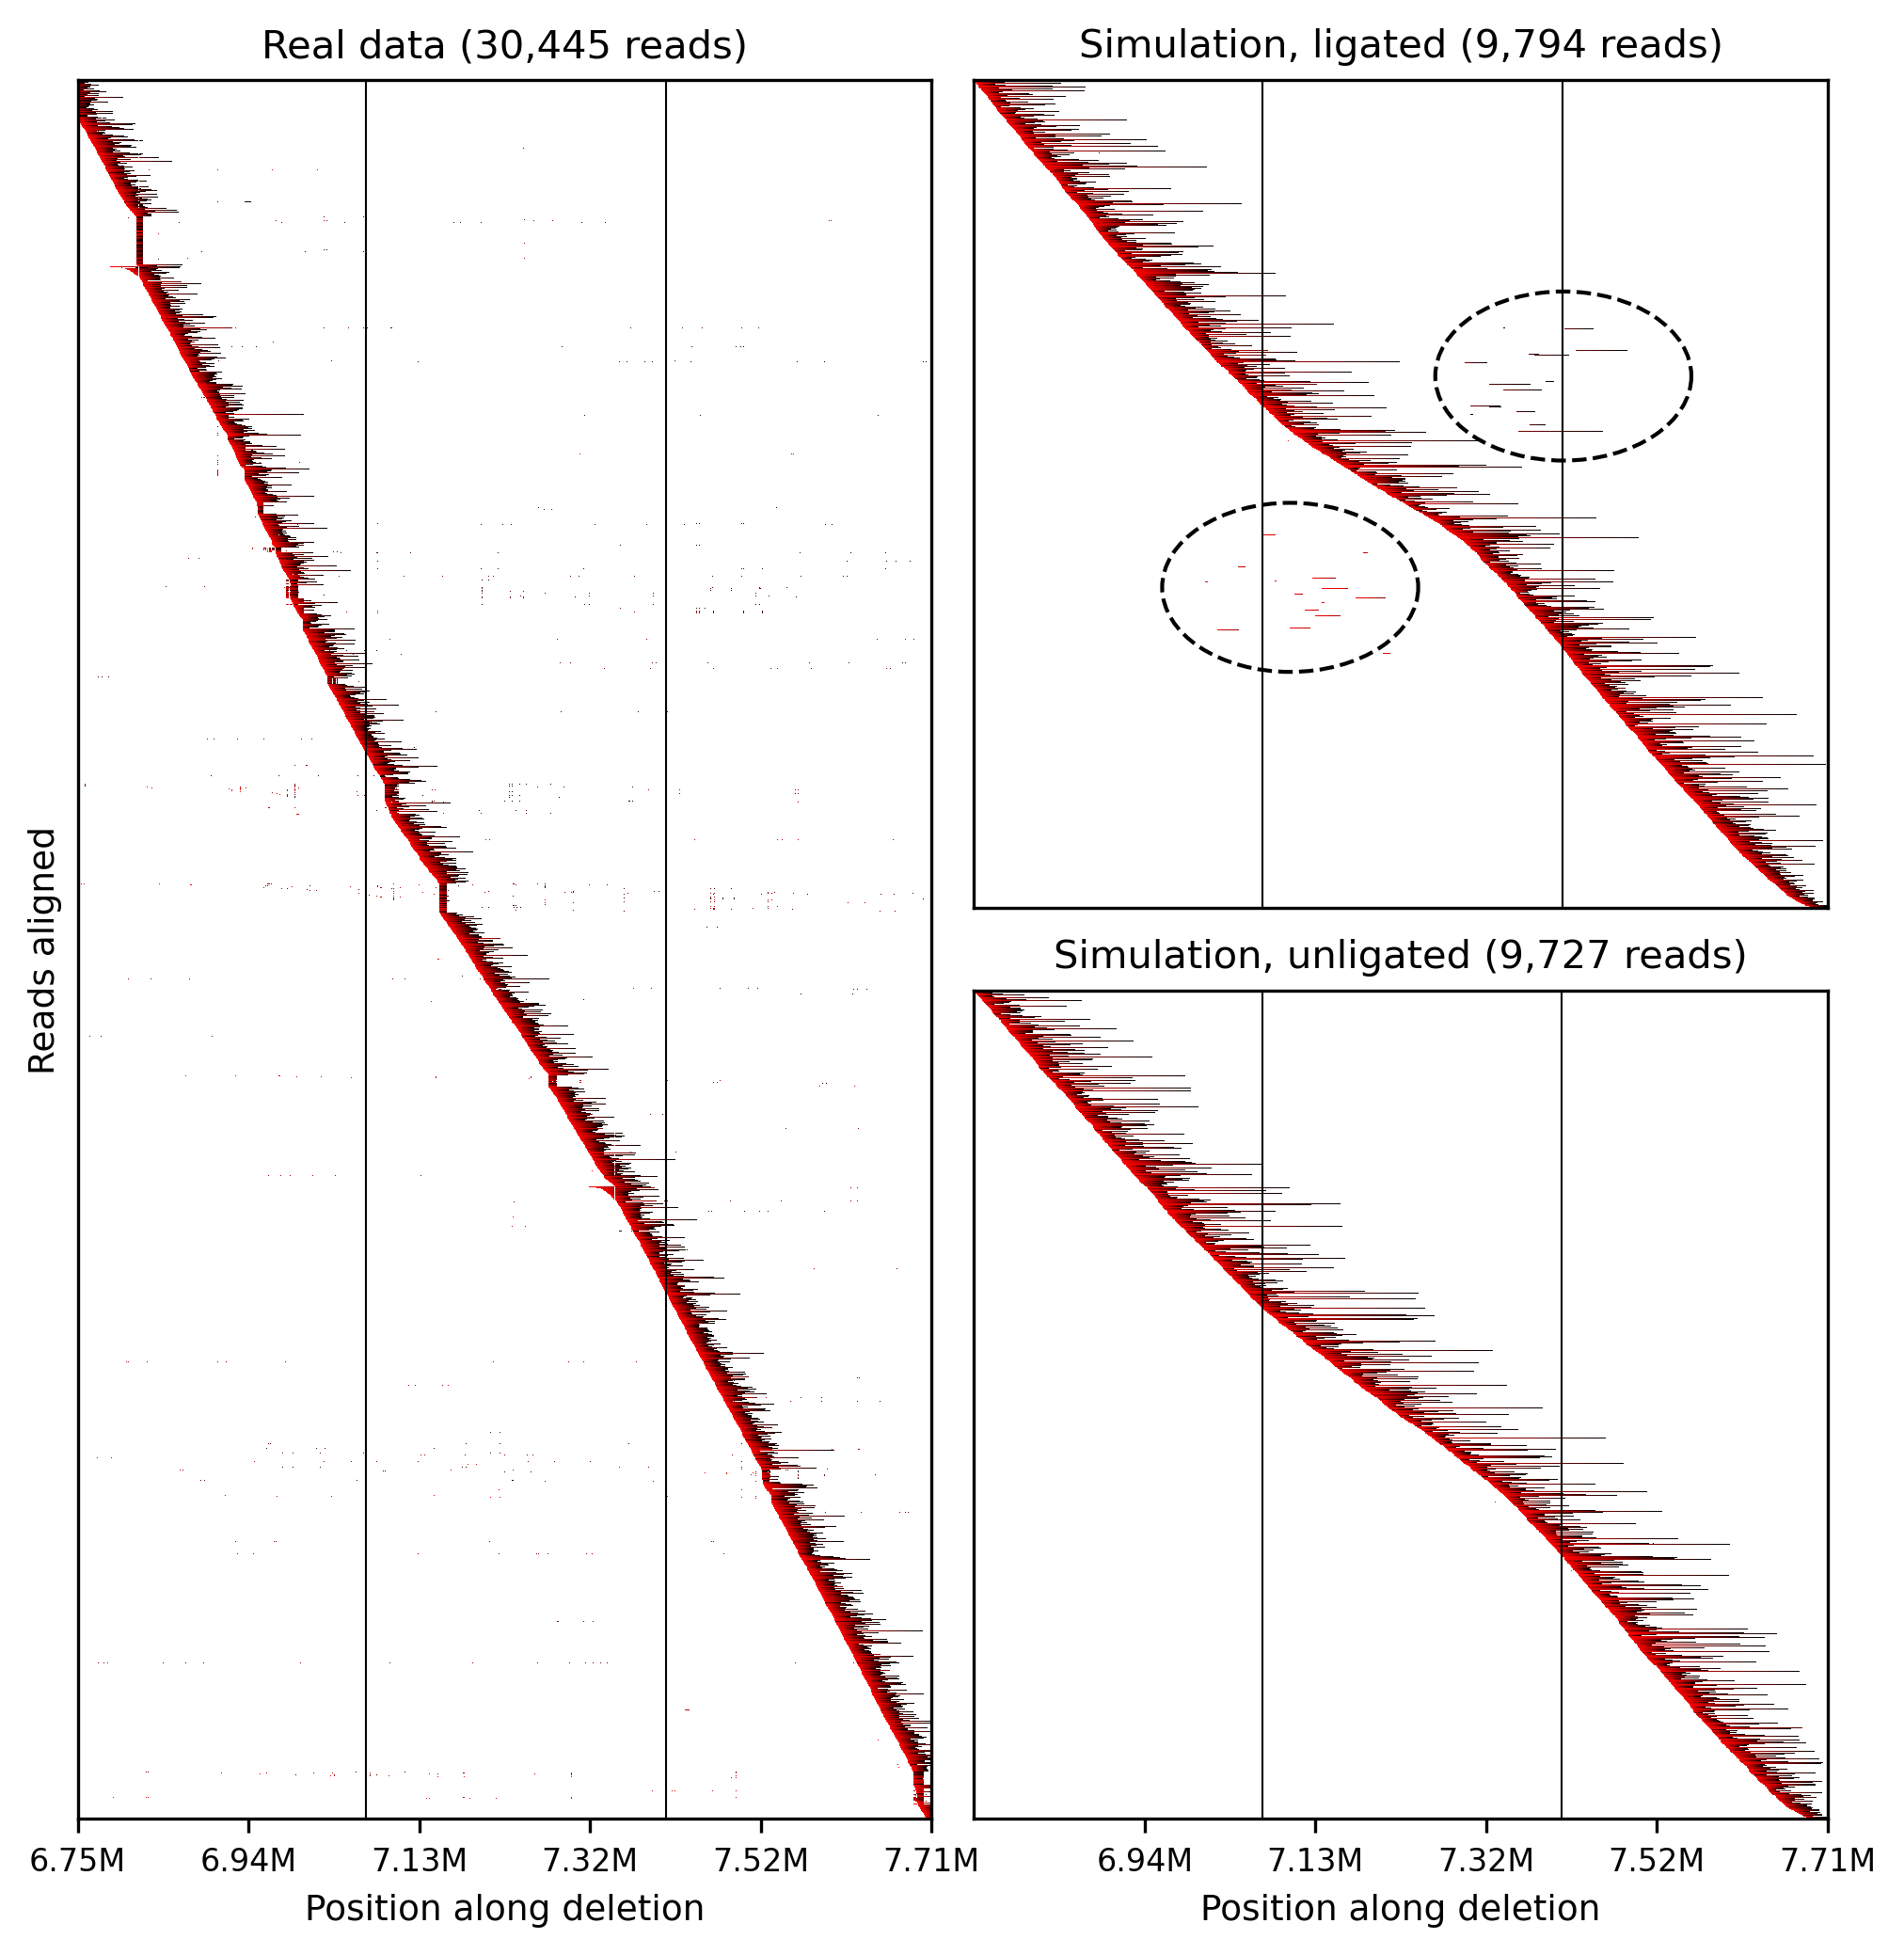

In [20]:
start=6749498
end=7706692
length=957195
delstart=7047000
delend=7383000

cmap = mpl.cm.seismic
colors = [(1, 0, 0), (0, 0, 0)] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=50)
cmap.set_bad(color='white')

fig = plt.figure(figsize=(8,8)) #subplots(nrows=2, ncols=2, figsize=(8,8))

gs = GridSpec(2, 2, figure=fig)
axs = []

# Ax column 0
ax1 = fig.add_subplot(gs[:,0])

masked_array = np.ma.array(matrix_real_sorted_by_start, mask=np.isnan(matrix_real_sorted_by_start))
ax1.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax1.set_title("Real data ({:,} reads)".format(len(masked_array)), fontsize=10)
ax1.set_ylabel("Reads aligned", fontsize=9)

# Ax 0,1
ax2 = fig.add_subplot(gs[0,1])

masked_array = np.ma.array (matrix_sim_reads_sorted_by_start, mask=np.isnan(matrix_sim_reads_sorted_by_start))
ax2.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax2.set_title("Simulation, ligated ({:,} reads)".format(len(masked_array)), fontsize=10)

# Ax 1,1
ax3 = fig.add_subplot(gs[1,1])

masked_array = np.ma.array (matrix_sim_reads2_sorted_by_start, mask=np.isnan(matrix_sim_reads2_sorted_by_start))
ax3.imshow(masked_array, cmap=cmap, aspect="auto", vmin=0.0, vmax=1.0, interpolation="none", zorder=1)
ax3.set_title("Simulation, unligated ({:,} reads)".format(len(masked_array)), fontsize=10)

for ax in [ax1,ax2,ax3] :
    ax.tick_params(axis="y", length=0)
    ax.set_yticks([])
    
    plot_del_start = int( ((end - delstart) / length)*1000 )
    plot_del_end = int( ((end - delend) / length)*1000 )
    ax.axvline(plot_del_start, 0, 1, lw=0.5, color="k") , #plot_del_end], ymin=0, ymax=len(matrix), color="k", zorder=10)
    ax.axvline(plot_del_end, 0, 1, lw=0.5, color="k")

for ax in [ax1,ax3] :
    ax.set_xlabel("Position along deletion", fontsize=9)
    ax.set_xlim(0,1000)
    
ax2.set_xticks([])

xticks = np.arange(0, 1001, 200)
ax1.set_xticks(xticks)
ax1.set_xticklabels(
    ["{:.2f}M".format( (start + int((i*(length/1000))))/1e6 ) for i in xticks],
    fontsize=8,
)

ax3.set_xticks(xticks[1:])
ax3.set_xticklabels(
    ["{:.2f}M".format( (start + int((i*(length/1000))))/1e6 ) for i in xticks[1:]],
    fontsize=8,
)

el = patches.Ellipse(
    (370, 6000), 2000, 300, angle=90,
    linewidth=1.0, fill=False, color="k", linestyle="dashed", zorder=15
)
ax2.add_patch(el)

el = patches.Ellipse(
    (690, 3500), 2000, 300, angle=90,
    linewidth=1.0, fill=False, color="k", linestyle="dashed", zorder=15
)
ax2.add_patch(el)

fig.subplots_adjust(wspace=0.05, hspace=0.1)

plt.show()